<img src="https://png.icons8.com/office/80/000000/museum.png" style="float: left; margin: 15px; height: 80px">

# Capstone Project

### Home Credit Default Risk

Strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience.

[Home Credit Default Risk data on kaggle](https://www.kaggle.com/c/home-credit-default-risk).

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

lgbm_categorical_feat = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']

def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df


# ------------------------- LIGHTGBM MODEL -------------------------

def kfold_lightgbm_sklearn(data, categorical_feature = None):
    df = data[data['TARGET'].notnull()]
    test = data[data['TARGET'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    test['TARGET'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['SK_ID_CURR'] = df['SK_ID_CURR'].copy()
        df['PREDICTIONS'] = oof_preds.copy()
        df['TARGET'] = df['TARGET'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        # Save submission (test data) and feature importance
        test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return mean_importance


# ------------------------- APPLICATION PIPELINE -------------------------

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    
    # 22 Nov 2018 - Not going to include the test set for now
    #test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    #df = train.append(test)
    #del train, test; gc.collect()
    df = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0


# ------------------------- BUREAU PIPELINE -------------------------

def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau


def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

# ------------------------- PREVIOUS PIPELINE -------------------------

def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

# ------------------------- POS-CASH PIPELINE -------------------------

def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg

# ------------------------- INSTALLMENTS PIPELINE -------------------------

def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg


def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

# ------------------------- CREDIT CARD PIPELINE -------------------------

def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg


# ------------------------- UTILITY FUNCTIONS -------------------------

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns


def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features


def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_


def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "/home/ubuntu/datasets/home_credit_default_risk"
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = False
STRATIFIED_KFOLD = False
RANDOM_SEED = 38
NUM_FOLDS = 5
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}

In [2]:
def get_df(debug= False):
    num_rows = 30000 if debug else None
    with timer("application_train and application_test"):
        df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)
        print("Application dataframe shape: ", df.shape)
    with timer("Bureau and bureau_balance data"):
        bureau_df = get_bureau(DATA_DIRECTORY, num_rows= num_rows)
        df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
        print("Bureau dataframe shape: ", bureau_df.shape)
        del bureau_df; gc.collect()
    with timer("previous_application"):
        prev_df = get_previous_applications(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
        ins = get_installment_payments(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
        cc = get_credit_card(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
        print("Credit card dataframe shape: ", cc.shape)
        del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)

    return df

In [3]:
#df = get_df()

In [4]:
#df.to_csv('home_credit_default_preprocessed_data.csv')

In [5]:
df = pd.read_csv('home_credit_default_preprocessed_data.csv')

<a id='tba'></a>
## Train and Test

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()


In [7]:
# Utility functions for train and test

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set(style='white')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
# AUC Plot Function
def plot_roc(clf, X_test, y_test):
    
    sns.set_style('whitegrid')

    # This best performing model happened to be last fitted on All training features so we can straightaway 
    # use it to get predicted Y on All test features
    Y_pp = pd.DataFrame(clf.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
        
    fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver operating characteristic for Model', fontsize=16)
    plt.legend(loc="lower right")
    print ('Auc:',roc_auc)       
    plt.show()


In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [10]:
#### create a new dataframe for storing results     
results = pd.DataFrame()

#### map the target values to names: 0 - Low Salary, 1 - High Salary
target_class = ['Good','Bad']

In [14]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn import metrics

def benchmark(clf,X_train,y_train,X_test,y_test, class_names, feature_description, to_cross_validate=False, to_smote_tomek=False, print_report=True, print_cm=True):
    
    is_multi_class =  True if (len(class_names) > 2) else False
    
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    
    if (to_smote_tomek):
        smt = SMOTETomek(random_state=38)
        X_train, y_train = smt.fit_sample(X_train, y_train)
    
    if type(clf)==XGBClassifier:
        eval_set = [(X_test, y_test)]
        clf.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set)
    elif type(clf)==LGBMClassifier: 
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)                
    else:
        clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)
    
    if (to_cross_validate):
        kfold = StratifiedKFold(n_splits=5, random_state=38)
        score = cross_val_score(clf, X_train, y_train, cv=kfold)    
        print("cross validation Score: {:0.3} ± {:0.3}".format(score.mean().round(3), score.std().round(3)))   

    t0 = time.time()
    pred_train = clf.predict(X_train)
    test_time = time.time() - t0
    print("test time on train set:  %0.3fs" % test_time)
        
    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time on test set:  %0.3fs" % test_time)

    accuracy_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % accuracy_score)

    roc_auc_score = None
    if (not is_multi_class):
        roc_auc_score_train = metrics.roc_auc_score(y_train, pred_train)
        print("auc_roc score for train data:   %0.3f" % roc_auc_score_train)
        
        roc_auc_score = metrics.roc_auc_score(y_test, pred)
        print("auc_roc score for test data:   %0.3f" % roc_auc_score)    

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("top 10 keywords per class:")
        # check multinomial or binary classification
        c = class_names if is_multi_class else [class_names[1]]
        for i, label in enumerate(c):        
            top_x_features = pd.DataFrame({'coef':clf.coef_[i],
                                'mag':np.abs(clf.coef_[i]),
                                'feature':X_train.columns}).sort_values('mag', ascending=True, inplace=False).tail(20)
            top_x_features.plot(kind='barh', figsize=(8,8))
            plt.yticks(range((len(top_x_features))), top_x_features['feature'])
            plt.title('Top Features for ' + label, fontsize=12)
        plt.show()        
        
    if hasattr(clf, 'feature_importances_'):        
        feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns).reset_index()
        feature_importances.columns = ['feature', 'importance']
        feature_importances.sort_values('importance', ascending=True, inplace=True)
        top_x_features = feature_importances.tail(20)
        top_x_features.plot(kind='barh', figsize=(8,8))
        plt.yticks(range((len(top_x_features))), top_x_features['feature'])
        plt.title('Top Features', fontsize=12)
        plt.show()
      
    if print_report:
        print("classification report on test:")
        print(metrics.classification_report(y_test, pred, target_names=class_names))

    if print_cm:
        
        cnf_matrix = metrics.confusion_matrix(y_train, pred_train)
        print("\nRecall metric in the training dataset: {:0.5}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
        print("Precision metric in the training dataset: {:0.5}".format(cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
        print("Confusion matrix:")
        print()           
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
        plt.show()        
        
        cnf_matrix = metrics.confusion_matrix(y_test, pred)
        print("\nRecall metric in the testing dataset: {:0.5}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
        print("Precision metric in the testing dataset: {:0.5}".format(cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
        print("Confusion matrix:")
        print()           
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
        plt.show()
      
    # plot roc curve
    print("\nPlot roc curve:")    
    plot_roc(clf, X_test, y_test)
    
    return {
        'Model': clf,
        'Features Used': feature_description,
        'Accuracy Score': accuracy_score,
        'ROC AUC Score': roc_auc_score
        }


In [12]:
# train test split
y = df['TARGET'].astype(int)
X = df.copy()
X.drop(columns=['SK_ID_CURR','TARGET'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38, stratify=y)

## for scikitlearn

In [11]:
X_train_nonnull = X_train.fillna(0) 
X_test_nonnull = X_test.fillna(0)

In [ ]:
X_train_nonnull

In [ ]:
X_train_nonnull_s = pd.DataFrame(ss.fit_transform(X_train_nonnull), columns=X_train_nonnull.columns)
X_test_nonnull_s = pd.DataFrame(ss.fit(X_test_nonnull), columns=X_test_nonnull_s.columns)

In [120]:
X = app_train.copy()

X.drop(columns=['SK_ID_CURR','TARGET'], inplace=True)

# replace nulls in numerical with median
#X = X.fillna(value={c:app_train[c].median() for c in app_train_numerical_column_names})
# replace nulls in numerical with mode
#X = X.fillna(value={c:app_train[c].mode()[0] for c in app_train_object_column_names}) 
X = X.fillna(0) 

#print('Any more nulls :')
#print(str(X.isnull().sum()[X.isnull().sum() > 0]))

print('Shape before get dummies ' + str(X.shape))
X = pd.get_dummies(X, drop_first=True)
print('Shape after get dummies ' + str(X.shape))

# train test split
y = app_train['TARGET'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38, stratify=y)


Shape before get dummies (307511, 120)
Shape after get dummies (307511, 228)


## Random Forest

In [15]:
X = app_train.copy()

X.drop(columns=['SK_ID_CURR','TARGET'], inplace=True)

X = im_replace_outliers_in_DAYS_EMPLOYED(X, np.nan)

# replace nulls in numerical with median
X = X.fillna(value={c:app_train[c].median() for c in app_train_numerical_column_names})
# replace nulls in numerical with mode
X = X.fillna(value={c:app_train[c].mode()[0] for c in app_train_object_column_names}) 

print('Any more nulls :')
print(X.isnull().sum()[X.isnull().sum() > 0])

# Add domain features
X = fe_add_domain_features(X)

print('Shape before get dummies ' + str(X.shape))
X = pd.get_dummies(X, drop_first=True)
print('Shape after get dummies ' + str(X.shape))

# train test split
y = app_train['TARGET'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38, stratify=y)

X_train_s = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
X_test_s = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

Any more nulls :
Series([], dtype: int64)
Shape before get dummies (307511, 125)
Shape after get dummies (307511, 233)


### RF Vanilla with Balanced Weights

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=38,
            verbose=0, warm_start=False)
train time: 98.457s
cross validation Score: 0.919 ± 0.0
test time on train set:  9.428s
test time on test set:  3.057s
accuracy:   0.919
auc_roc score for train data:   1.000
auc_roc score for test data:   0.501


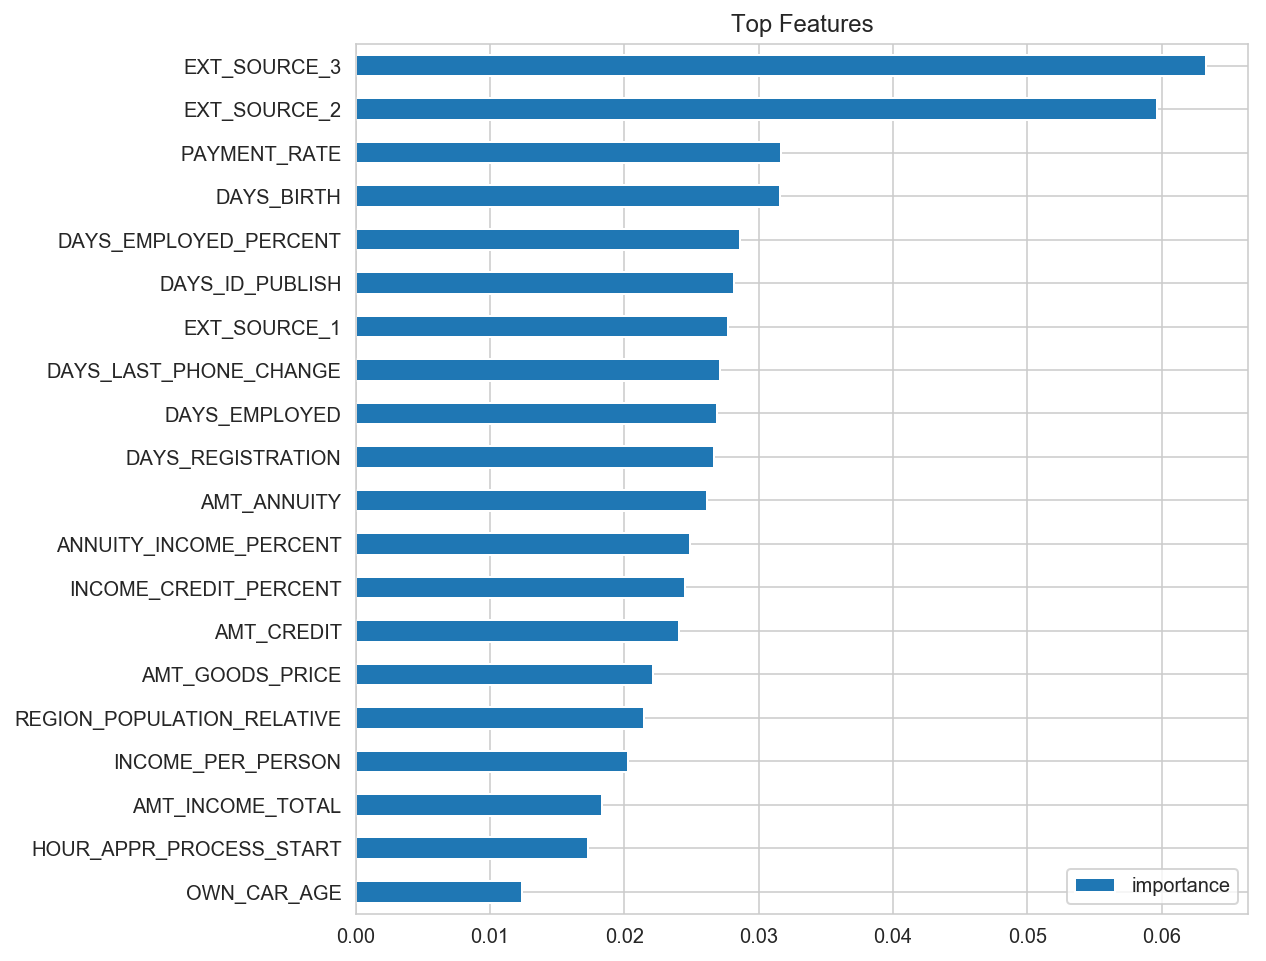

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.54      0.00      0.00      6206

avg / total       0.89      0.92      0.88     76878


Recall metric in the training dataset: 99.952
Precision metric in the training dataset: 99.996
Confusion matrix:



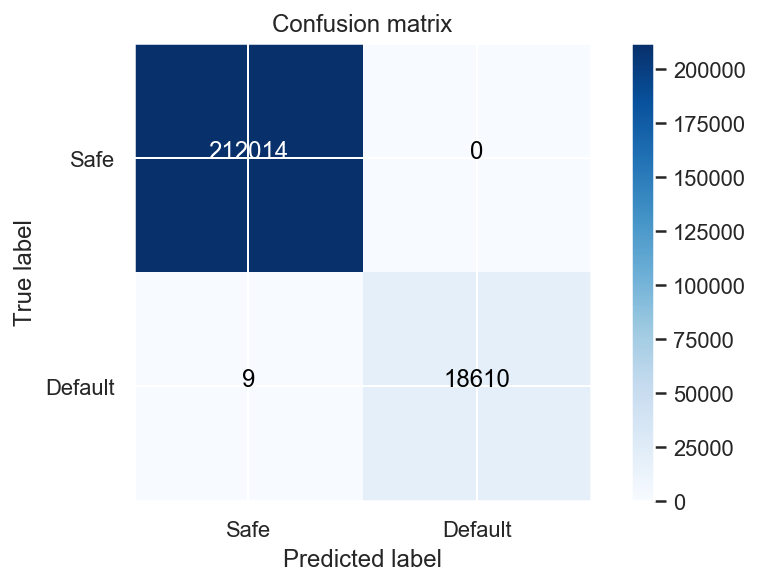


Recall metric in the testing dataset: 0.22558814050918466%
Precision metric in the testing dataset: 91.9429552906886%
Confusion matrix:



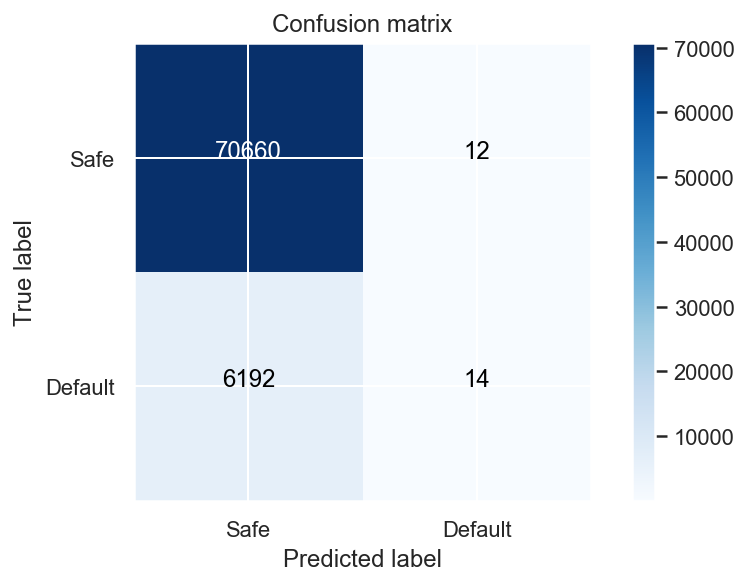


Plot roc curve:
Auc: 0.7164293235197617


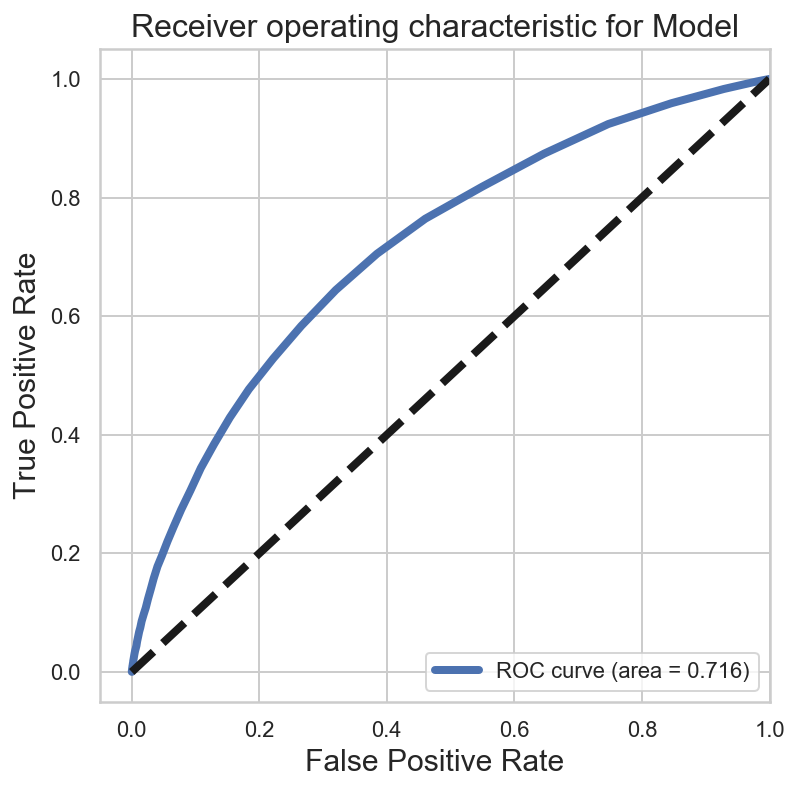

In [22]:
# All params are taken from library defaults.
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_features='auto', 
    min_impurity_decrease=0.0, 
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=100, oob_score=False, random_state=38, verbose=0,
    warm_start=False)

results = results.append(benchmark(rf_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='RF Baseline'), ignore_index=True)


In [28]:
results

Accuracy Score Features Used  \
0        0.919301   RF Baseline   

                                               Model  ROC AUC Score  
0  (DecisionTreeClassifier(class_weight=None, cri...       0.501043

### RF with Balanced Weights Grid Search

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 98.2min finished


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=38,
            verbose=0, warm_start=False)
train time: 105.703s
cross validation Score: 0.818 ± 0.001
test time on train set:  9.151s
test time on test set:  3.129s
accuracy:   0.808
auc_roc score for train data:   0.837
auc_roc score for test data:   0.636


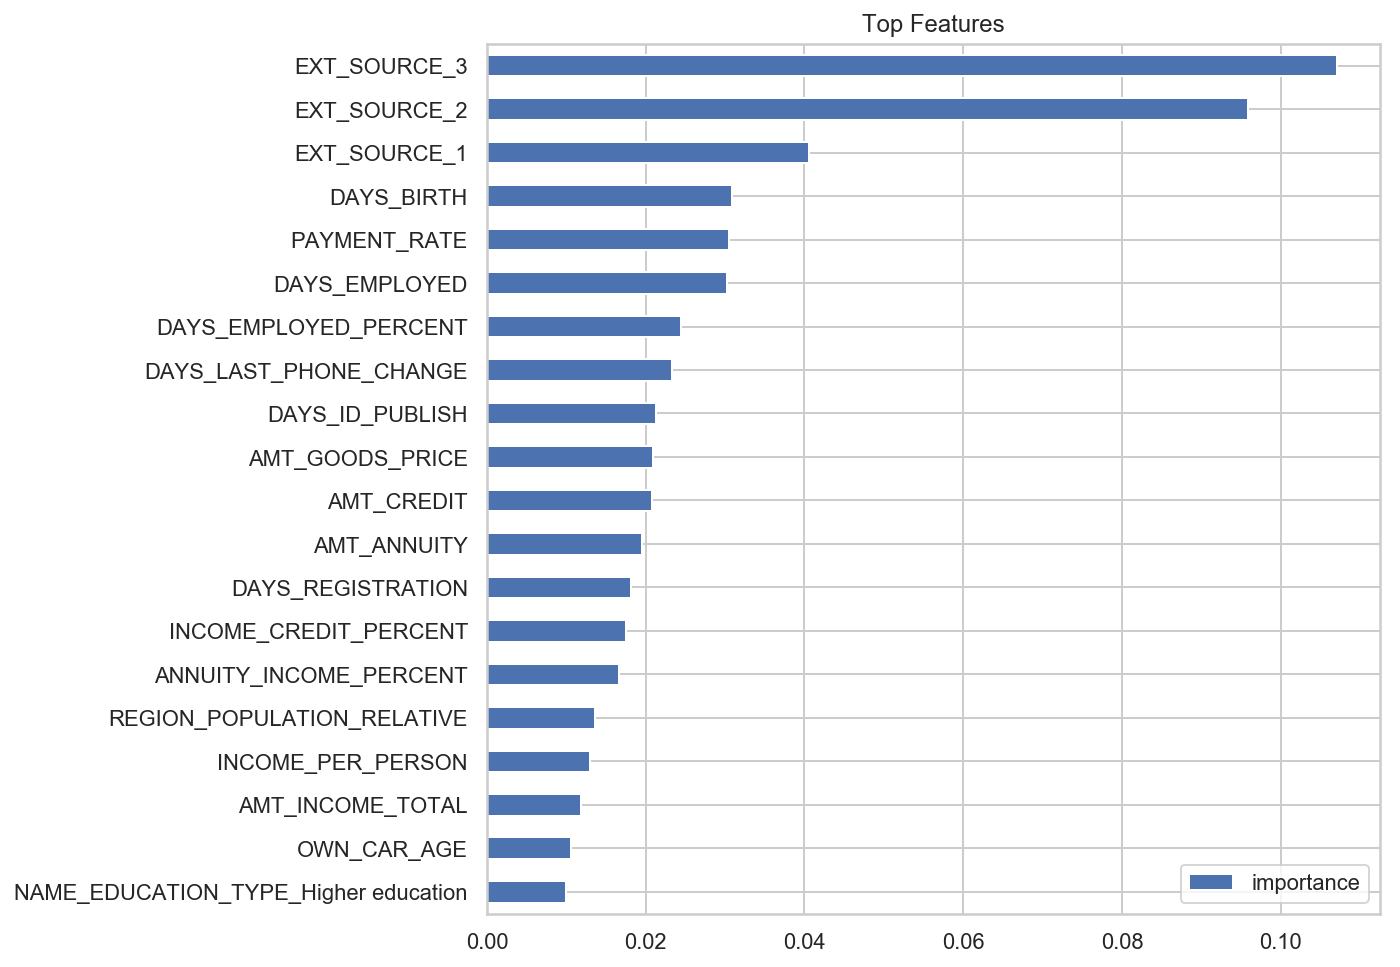

classification report on test:
             precision    recall  f1-score   support

       Safe       0.94      0.84      0.89     70672
    Default       0.19      0.43      0.27      6206

avg / total       0.88      0.81      0.84     76878


Recall metric in the training dataset: 0.82179
Precision metric in the training dataset: 0.98197
Confusion matrix:



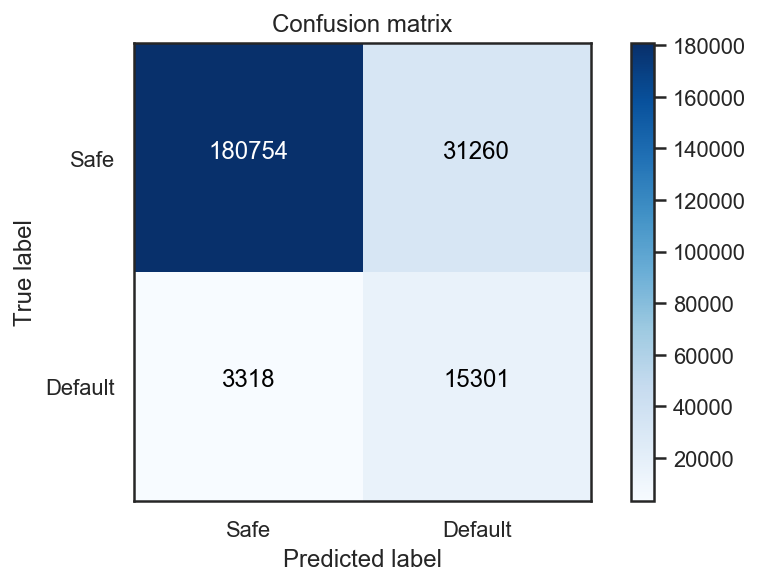


Recall metric in the testing dataset: 0.43232%
Precision metric in the testing dataset: 0.94402%
Confusion matrix:



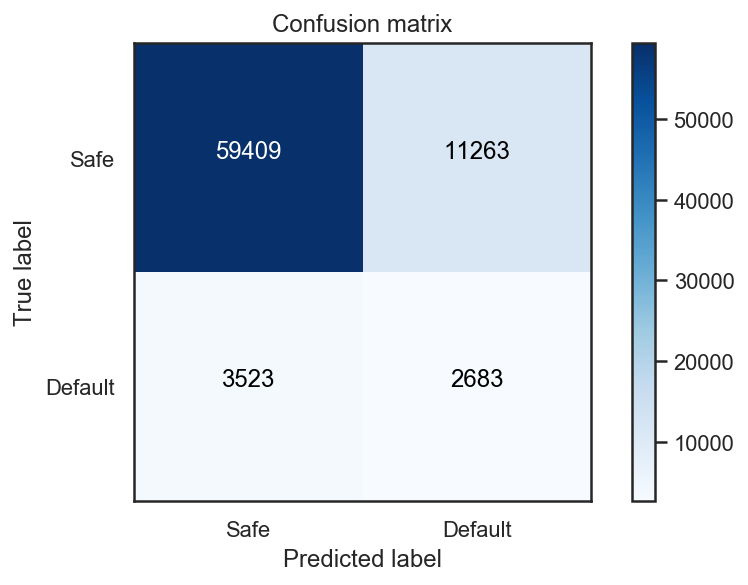


Plot roc curve:
Auc: 0.7162899714146067


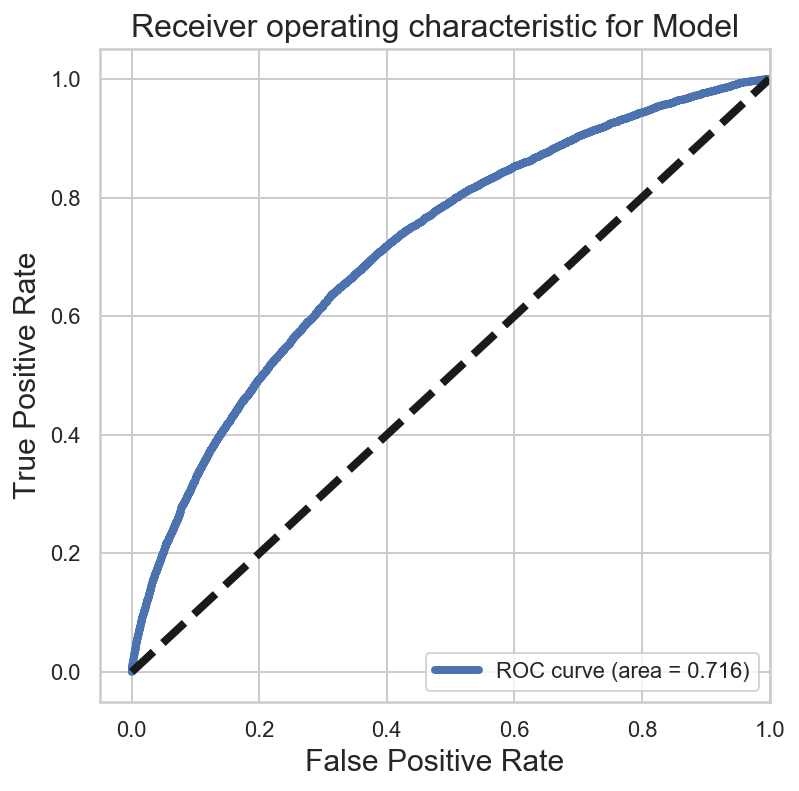

In [31]:
param_grid = {'n_estimators': [30, 50, 100, 150],
             'max_depth':[10, 15]}

# fit gridsearch with model, param_grid, cv_tir
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=38)
grid_rfc_gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=38), param_grid, cv=kfold, verbose=1)

#fit model
grid_rfc_gs.fit(X_train, y_train)

# get best param
grid_rfc_gs.best_params_
model_rfc_gs = grid_rfc_gs.best_estimator_

results = results.append(benchmark(model_rfc_gs, X_train, y_train, X_test, y_test, target_class ,feature_description='RF GridSearched with Added Domain Features'), ignore_index=True)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 355.9min finished


________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=38,
            verbose=0, warm_start=False)
train time: 283.072s
cross validation Score: 0.913 ± 0.001
test time on train set:  54.246s
test time on test set:  9.777s
accuracy:   0.912
auc_roc score for train data:   0.996
auc_roc score for test data:   0.534


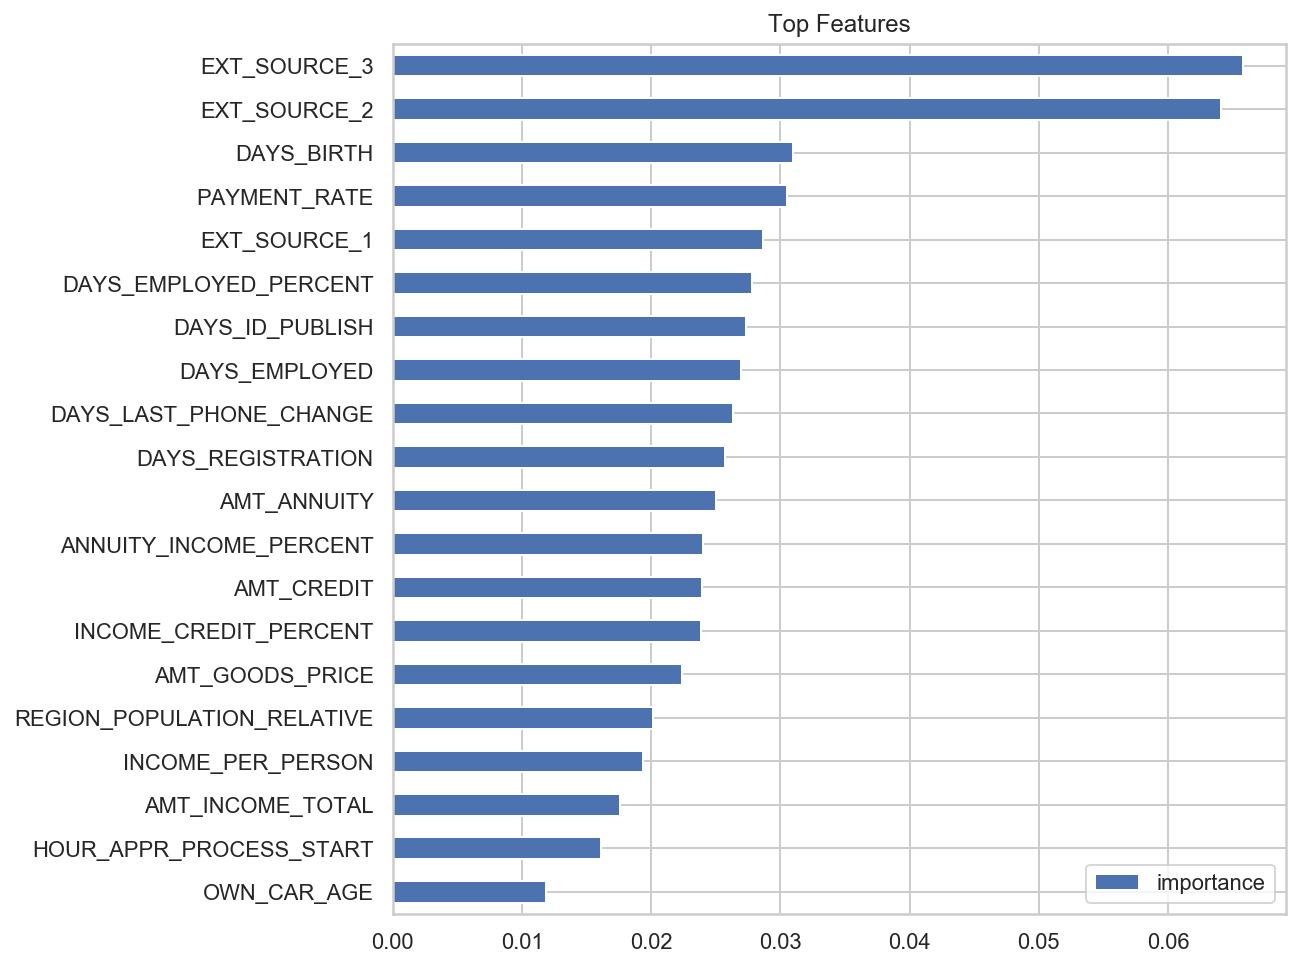

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      0.98      0.95     70672
    Default       0.32      0.08      0.13      6206

avg / total       0.88      0.91      0.89     76878


Recall metric in the training dataset: 0.99941
Precision metric in the training dataset: 0.99995
Confusion matrix:



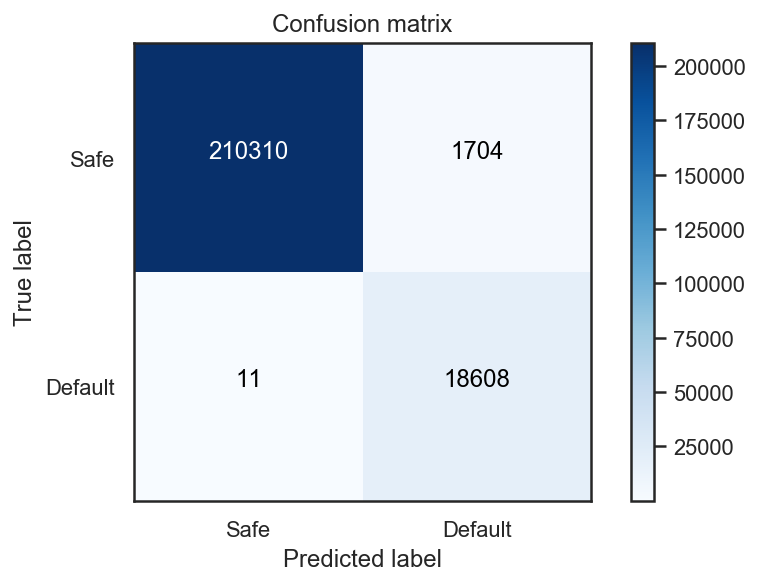


Recall metric in the testing dataset: 0.084273%
Precision metric in the testing dataset: 0.92448%
Confusion matrix:



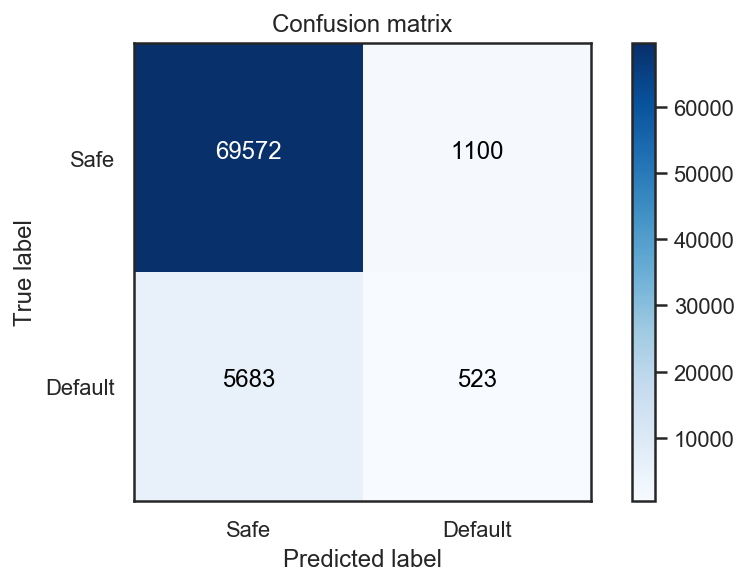


Plot roc curve:
Auc: 0.7224237554730788


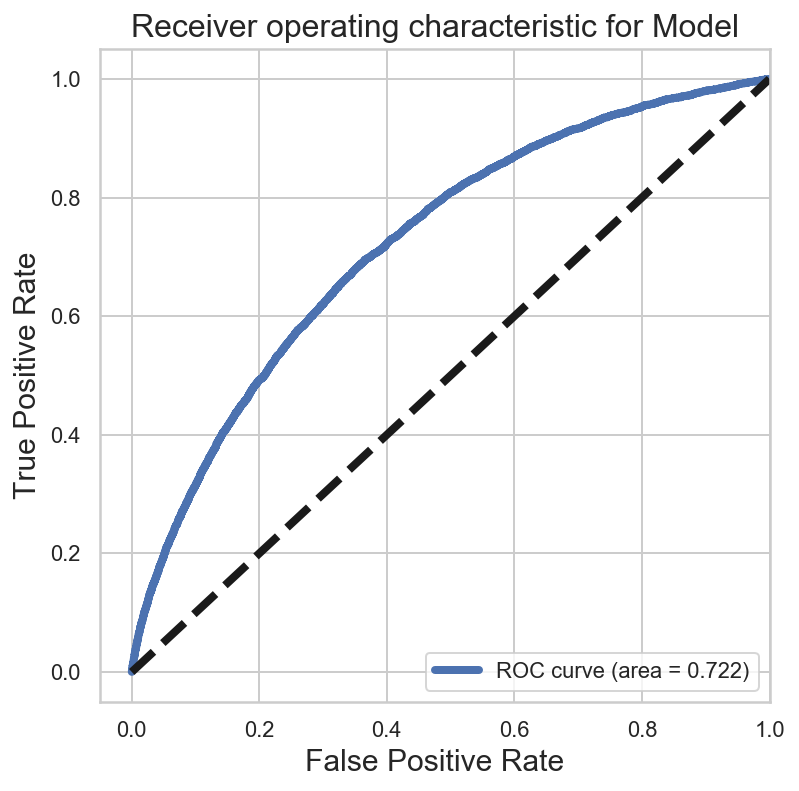

In [32]:
param_grid = {'n_estimators': [200, 300],
             'max_depth':[15, 30]}

# fit gridsearch with model, param_grid, cv_tir
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=38)
grid_rfc_gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=38), param_grid, cv=kfold, verbose=1)

#fit model
grid_rfc_gs.fit(X_train, y_train)

# get best param
grid_rfc_gs.best_params_
model_rfc_gs = grid_rfc_gs.best_estimator_

results = results.append(benchmark(model_rfc_gs, X_train, y_train, X_test, y_test, target_class ,feature_description='RF GridSearched with Added Domain Features'), ignore_index=True)

### RF with Max Depth = 10, n_estimators=150

From the above two, it looks like max_depth = 15 performs better on the test set likely due to less overfitting on the train.  Will try max_depth=10, 100 estimators on the test set see if will outperform 150

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False, random_state=38,
            verbose=3, warm_start=False)
building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150building tree 15 of 150

building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tre

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s


building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150building tree 36 of 150

building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.8s


building tree 121 of 150
building tree 122 of 150
building tree 123 of 150
building tree 124 of 150
building tree 125 of 150
building tree 126 of 150
building tree 127 of 150
building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   23.3s finished


train time: 23.994s
cross validation Score: 0.732 ± 0.003


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.5s finished


test time on train set:  2.177s


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.4s finished


test time on test set:  0.699s
accuracy:   0.727
auc_roc score for train data:   0.726
auc_roc score for test data:   0.663


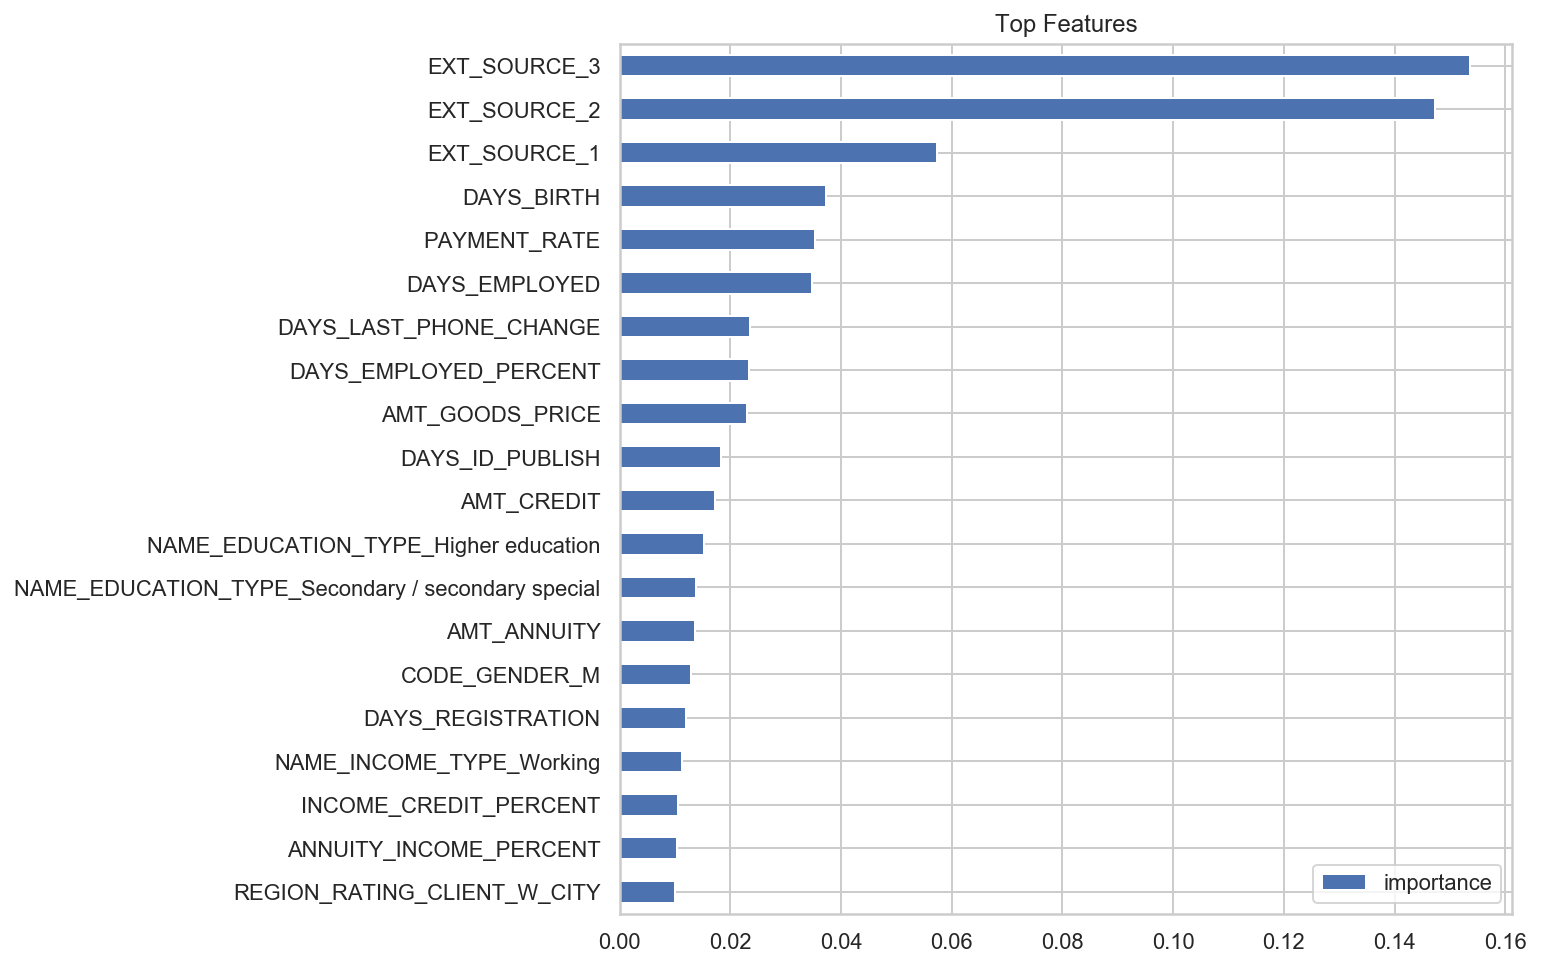

classification report on test:
             precision    recall  f1-score   support

       Safe       0.95      0.74      0.83     70672
    Default       0.16      0.59      0.26      6206

avg / total       0.89      0.73      0.79     76878


Recall metric in the training dataset: 0.71013
Precision metric in the training dataset: 0.96687
Confusion matrix:



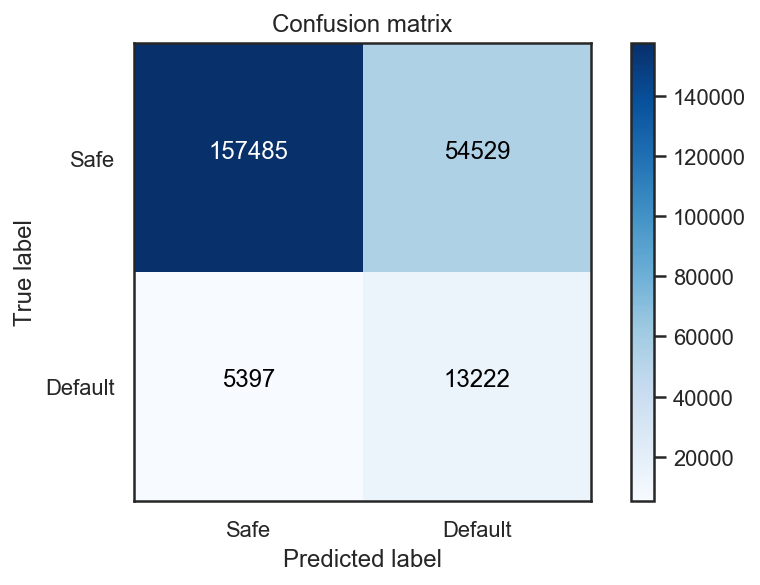


Recall metric in the testing dataset: 0.58637%
Precision metric in the testing dataset: 0.95315%
Confusion matrix:



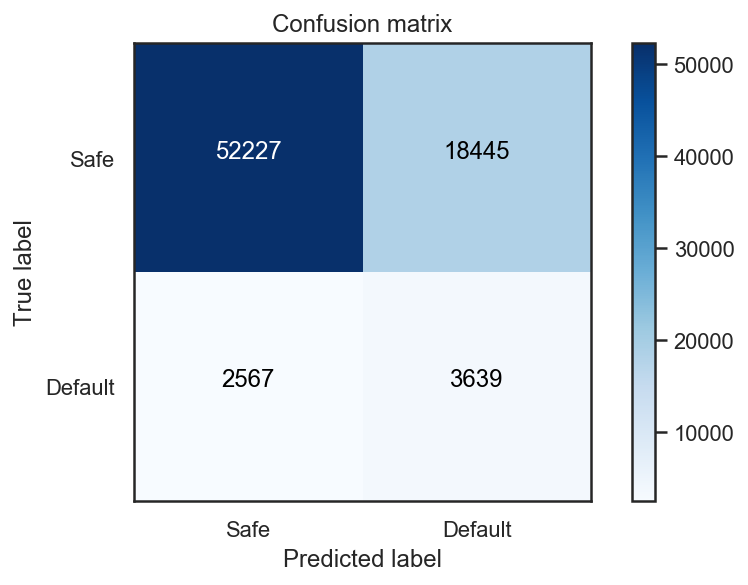


Plot roc curve:


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.4s finished


Auc: 0.7238241873001006


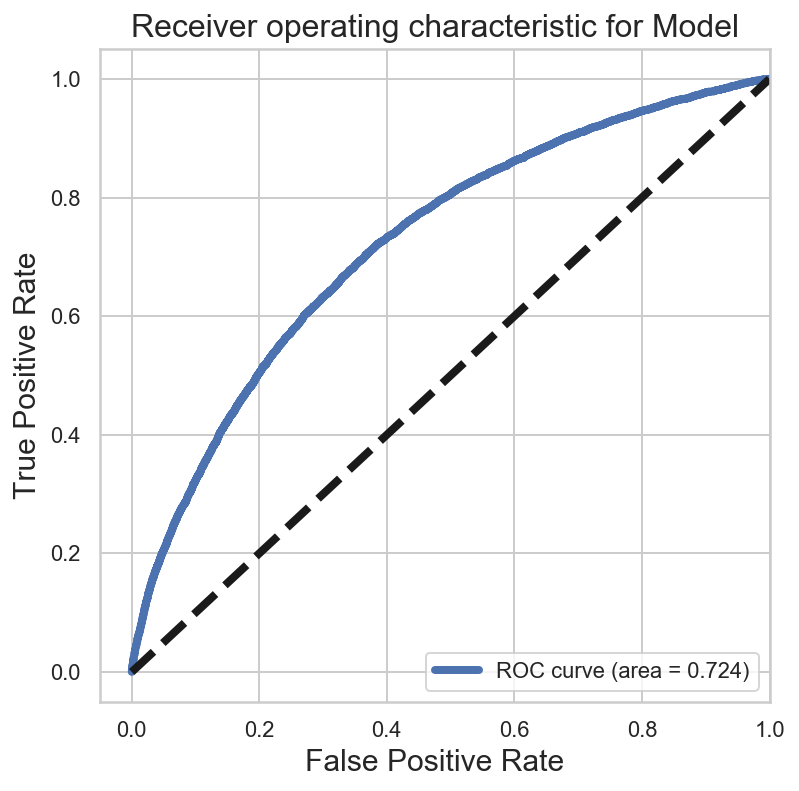

In [33]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False, random_state=38,
            verbose=3, warm_start=False)

results = results.append(benchmark(rf_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='RF max_depth=10, n_estimators=150'), ignore_index=True)

###  RF with Max Depth = 8, n_estimators=300

From the above two, it looks like max_depth = 15 performs better on the test set likely due to less overfitting on the train.  Will try max_depth=8, 300 estimators on the test set see if will outperform 150

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=38,
            verbose=3, warm_start=False)
building tree 1 of 300building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300

building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300building tree 36 of 300

building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.6s


building tree 122 of 300
building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   52.8s


building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   56.1s finished


train time: 58.237s
cross validation Score: 0.701 ± 0.002


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    2.4s finished


test time on train set:  3.044s


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.7s finished


test time on test set:  1.131s
accuracy:   0.697
auc_roc score for train data:   0.698
auc_roc score for test data:   0.664


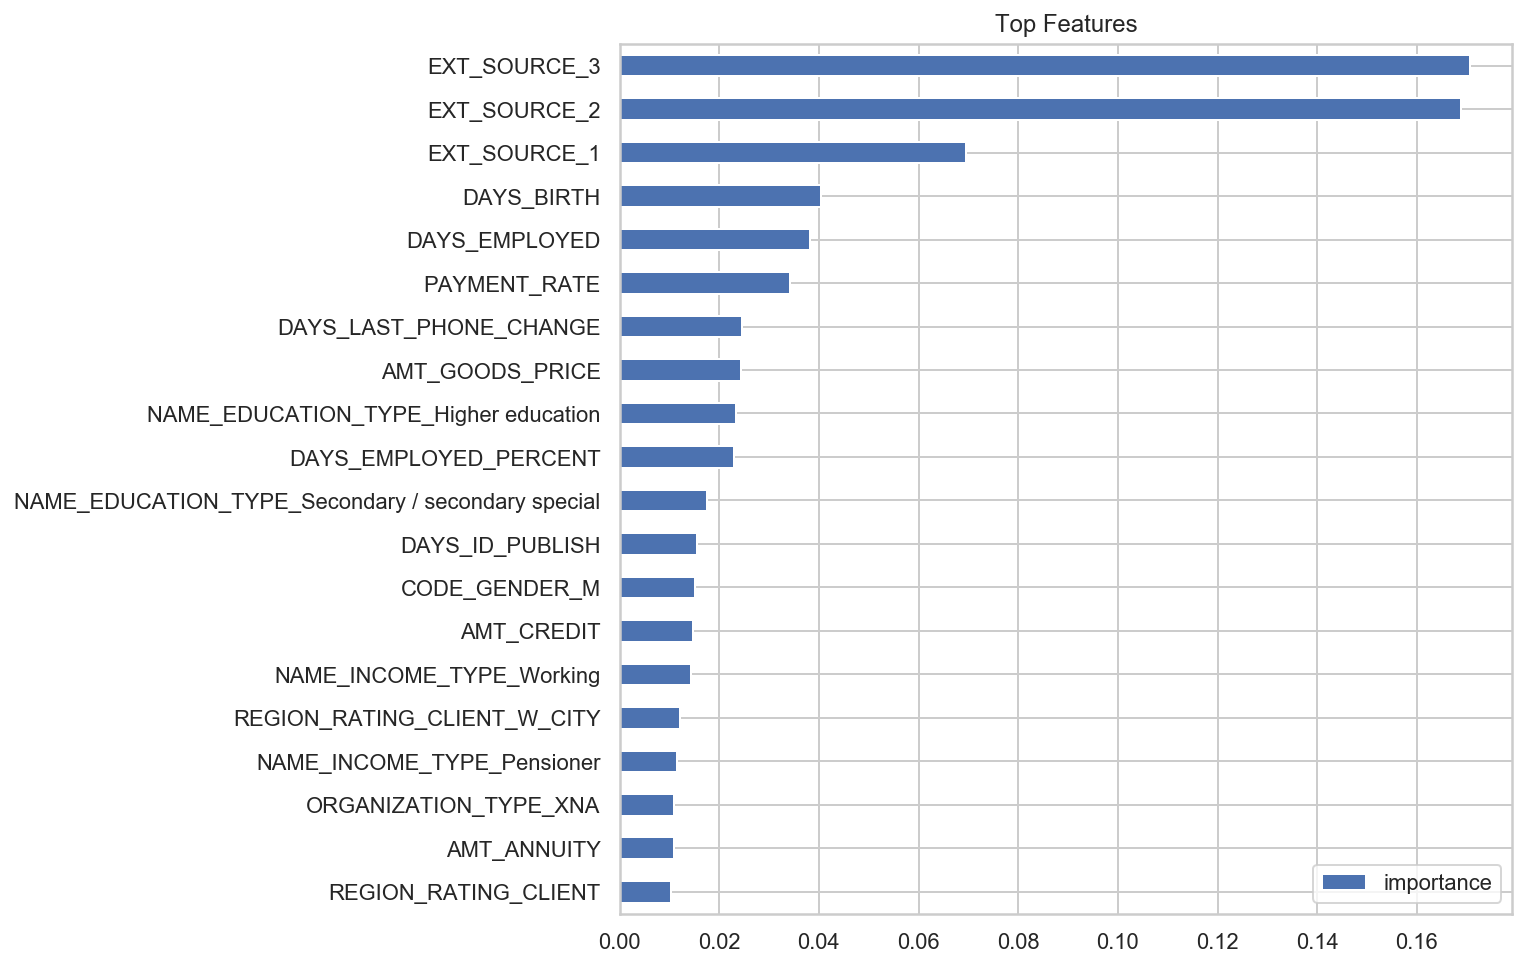

classification report on test:
             precision    recall  f1-score   support

       Safe       0.96      0.70      0.81     70672
    Default       0.16      0.62      0.25      6206

avg / total       0.89      0.70      0.77     76878


Recall metric in the training dataset: 0.6908
Precision metric in the training dataset: 0.96296
Confusion matrix:



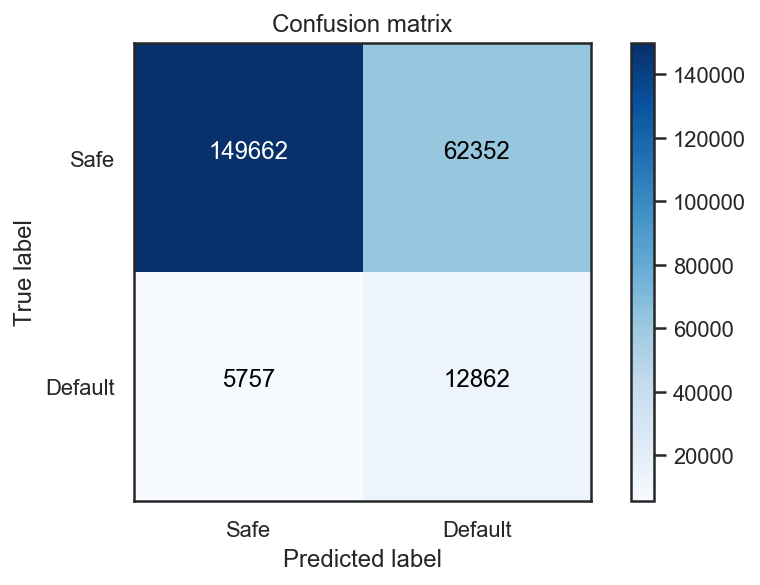


Recall metric in the testing dataset: 0.62472
Precision metric in the testing dataset: 0.95525
Confusion matrix:



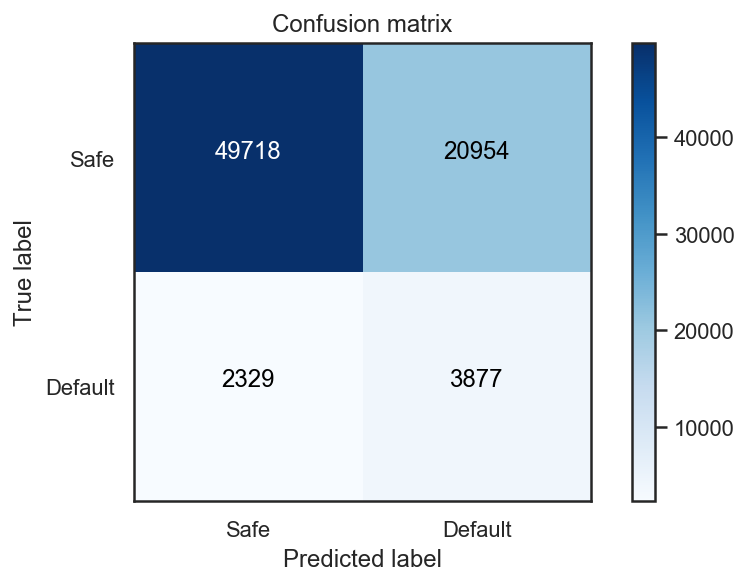


Plot roc curve:


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.6s finished


Auc: 0.7217508018961982


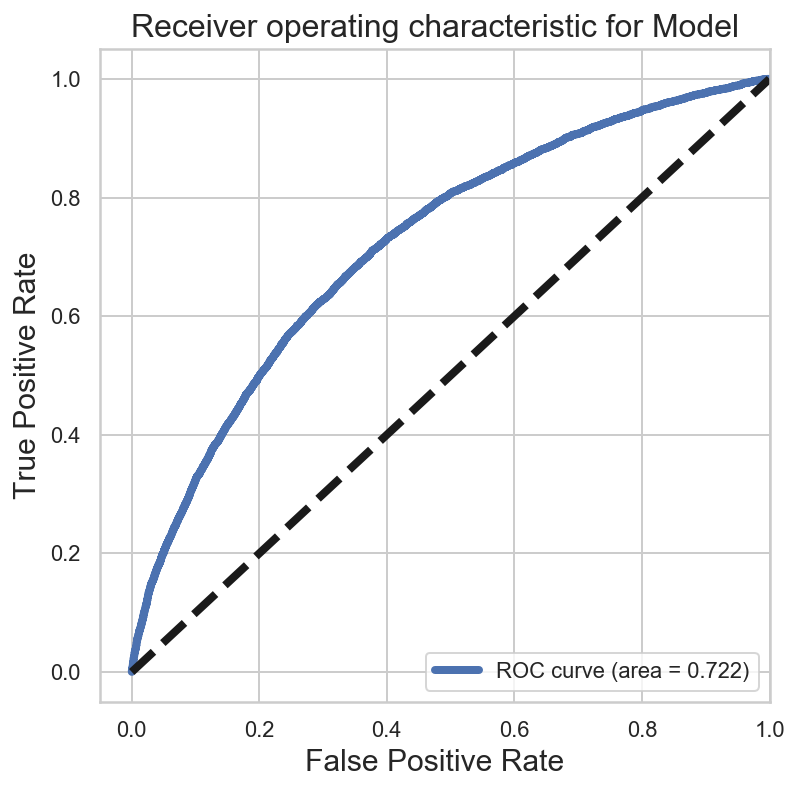

In [37]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=38,
            verbose=2, warm_start=False)

results = results.append(benchmark(rf_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='RF max_depth=10, n_estimators=150'), ignore_index=True)

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.6s finished


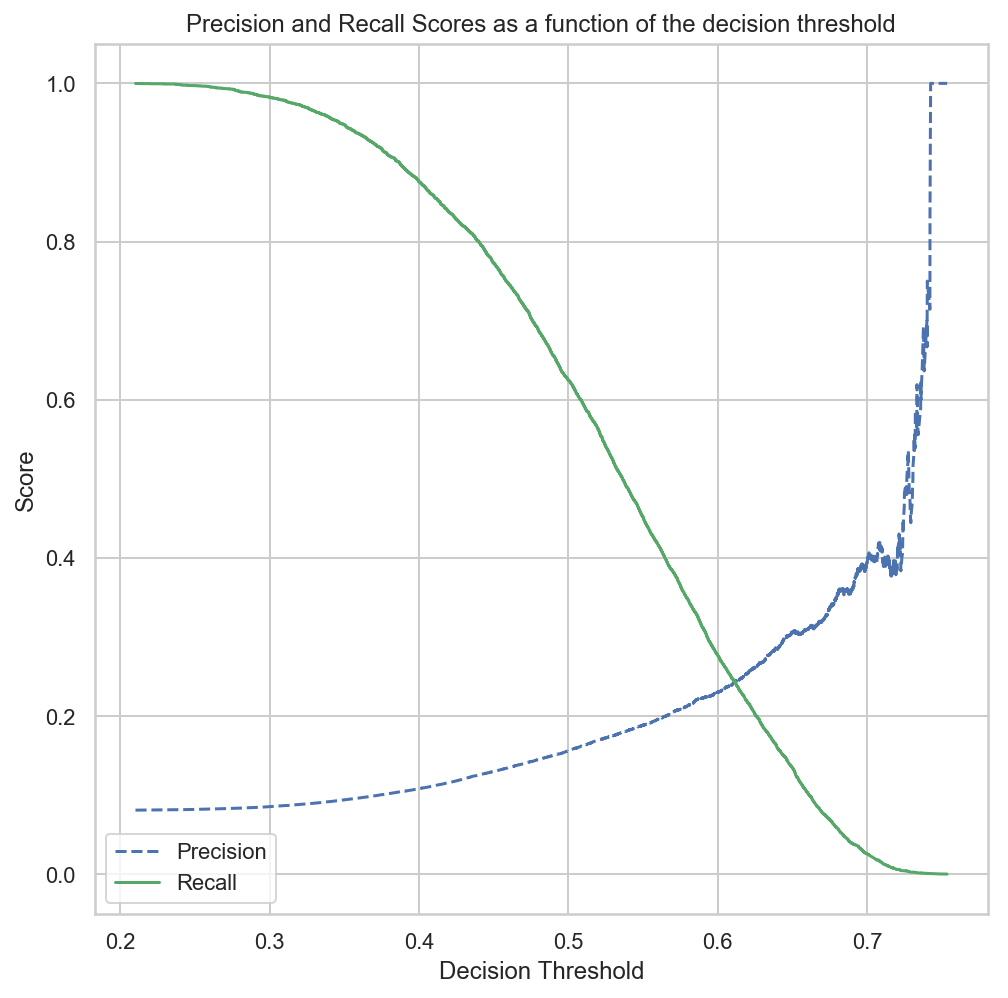

In [42]:
y_scores = rf_clf.predict_proba(X_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

plot_precision_recall_vs_threshold1(p, r, thresholds)

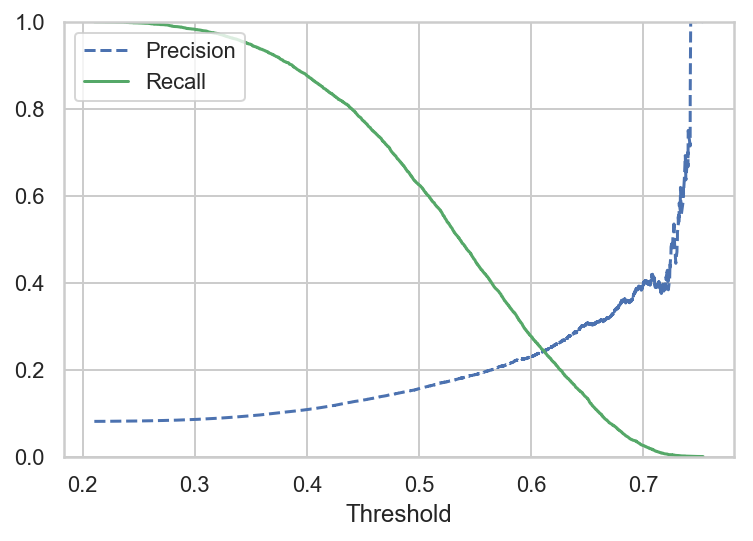

In [45]:
plot_precision_recall_vs_threshold2(p, r, thresholds)

In [ ]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=38,
            verbose=2, warm_start=False)

results = results.append(benchmark(rf_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='RF max_depth=10, n_estimators=150'), ignore_index=True)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=38,
            verbose=2, warm_start=False)
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500building tree 56 of 500

building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s


building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.5s


building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


train time: 65.082s
cross validation Score: 0.702 ± 0.002


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    4.5s finished


test time on train set:  5.343s


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.3s finished


test time on test set:  1.681s
accuracy:   0.698
auc_roc score for train data:   0.699
auc_roc score for test data:   0.664


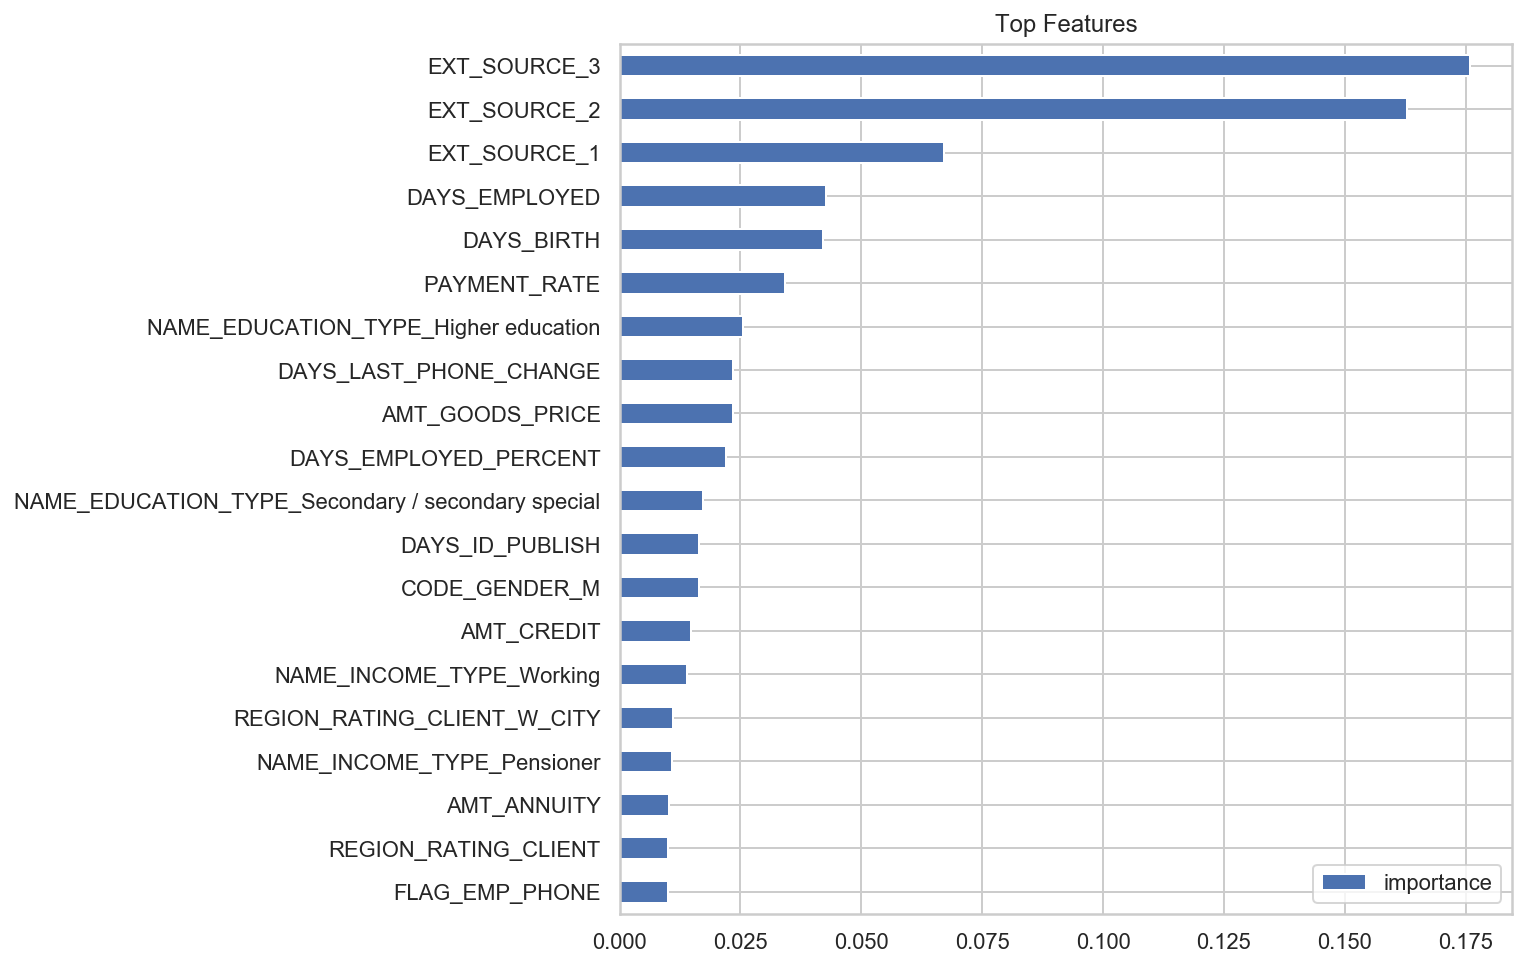

classification report on test:
             precision    recall  f1-score   support

       Good       0.96      0.70      0.81     70672
        Bad       0.16      0.62      0.25      6206

avg / total       0.89      0.70      0.77     76878


Recall metric in the training dataset: 0.69198
Precision metric in the training dataset: 0.96313
Confusion matrix:



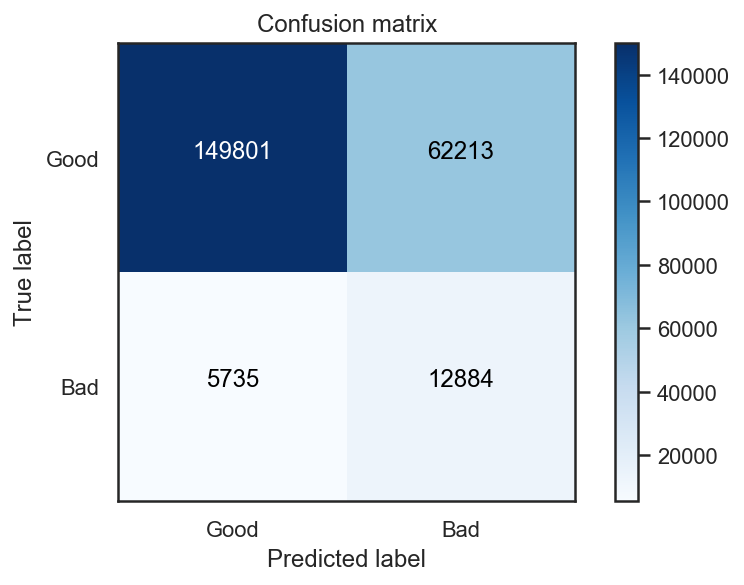


Recall metric in the testing dataset: 0.62343
Precision metric in the testing dataset: 0.95514
Confusion matrix:



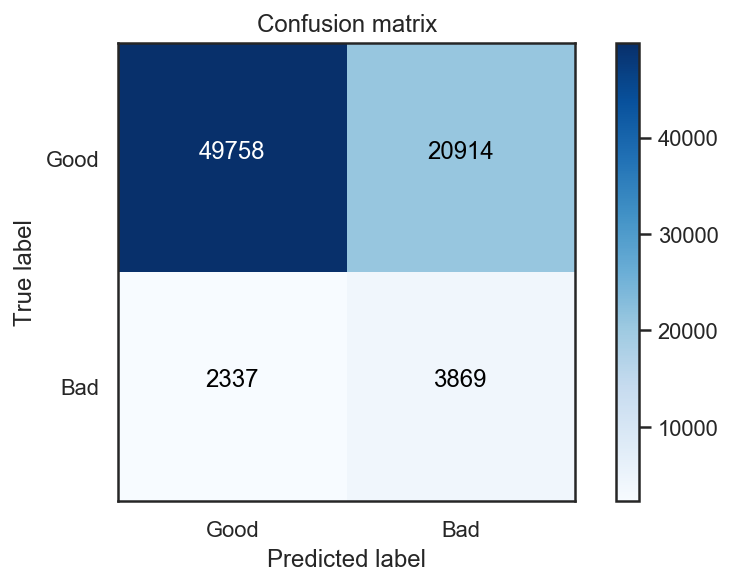


Plot roc curve:


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.2s finished


Auc: 0.722034731938703


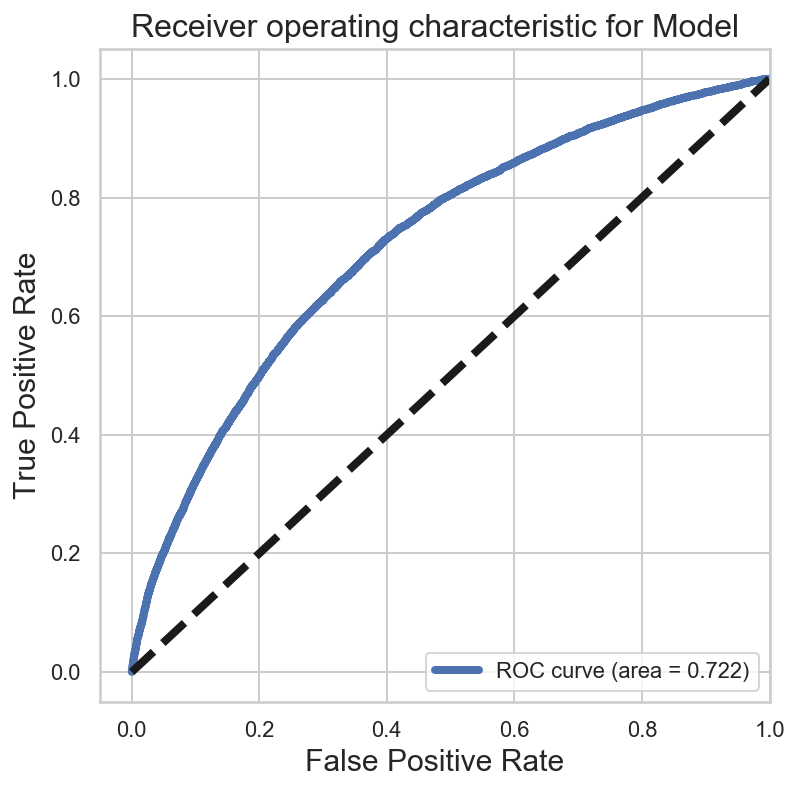

In [46]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=38,
            verbose=2, warm_start=False)

results = results.append(benchmark(rf_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='RF max_depth=8, n_estimators=500'), ignore_index=True)

## XGBoost

________________________________________________________________________________
Training: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=5000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)
train time: 2595.933s
cross validation Score: 0.92 ± 0.0


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on train set:  20.552s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on test set:  6.752s
accuracy:   0.919
auc_roc score for train data:   0.521
auc_roc score for test data:   0.514


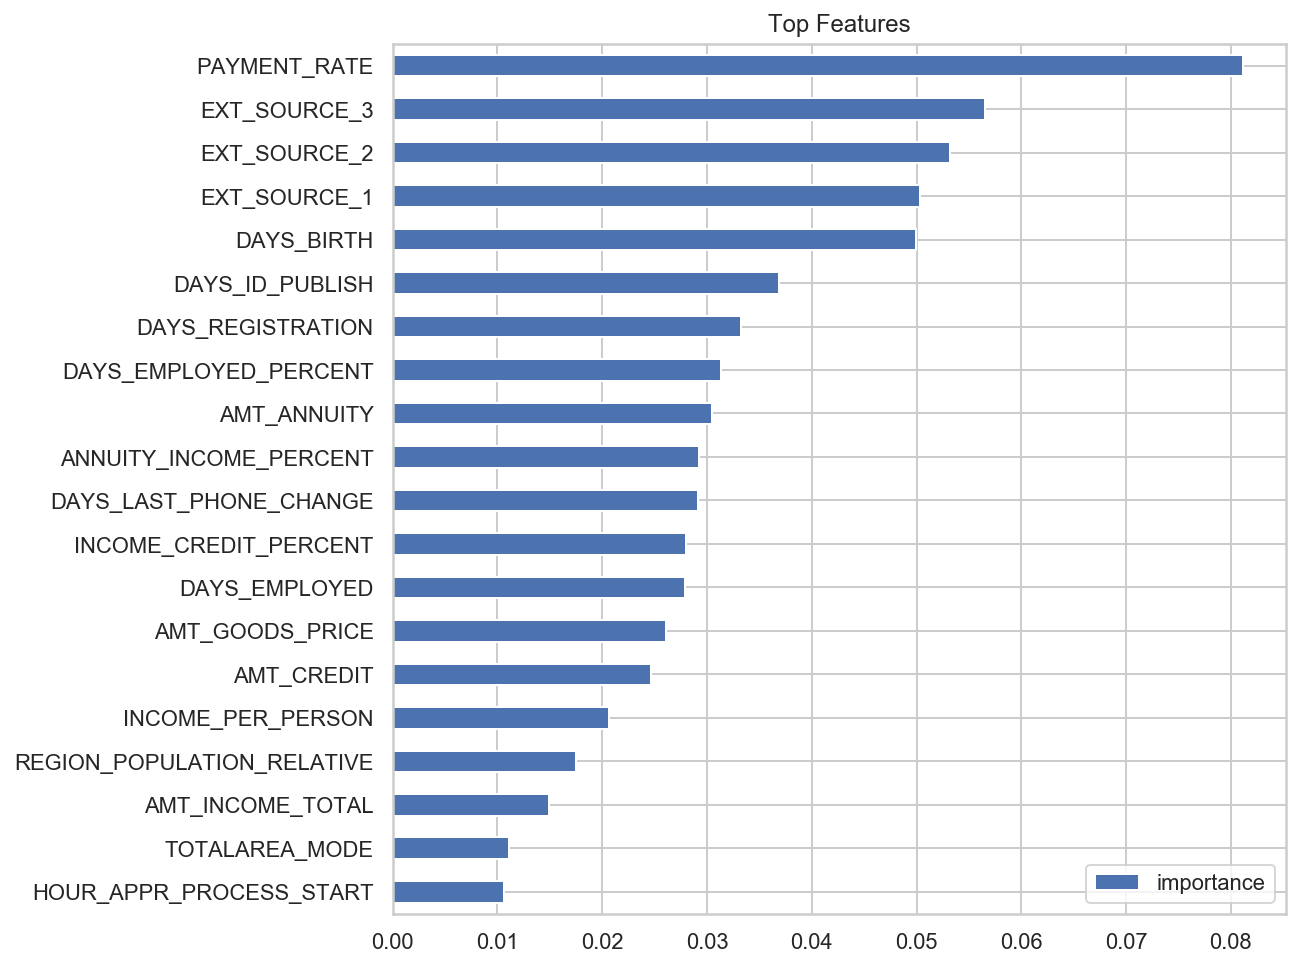

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.52      0.03      0.06      6206

avg / total       0.89      0.92      0.89     76878


Recall metric in the training dataset: 0.042967
Precision metric in the training dataset: 0.92237
Confusion matrix:



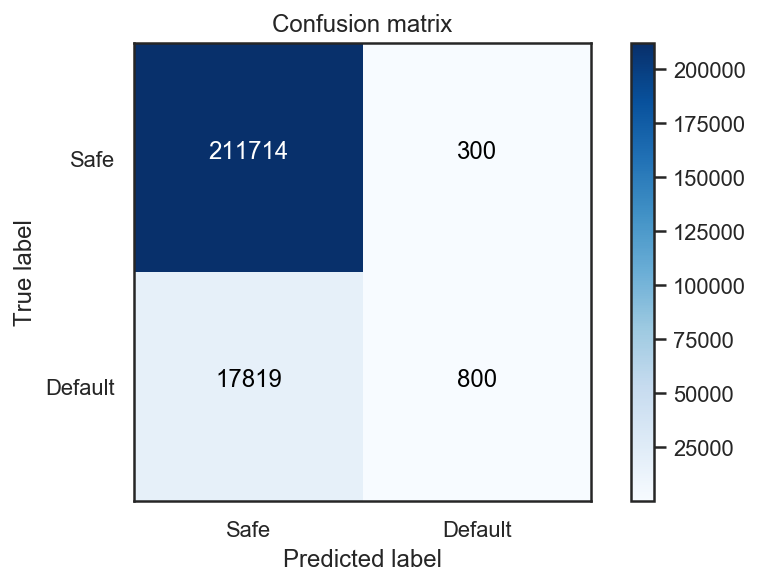


Recall metric in the testing dataset: 0.030616
Precision metric in the testing dataset: 0.92137
Confusion matrix:



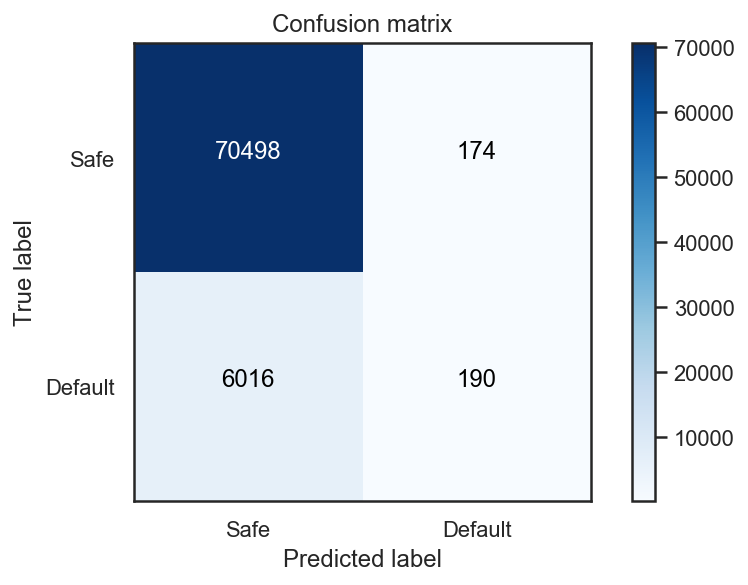


Plot roc curve:
Auc: 0.7620818036906012


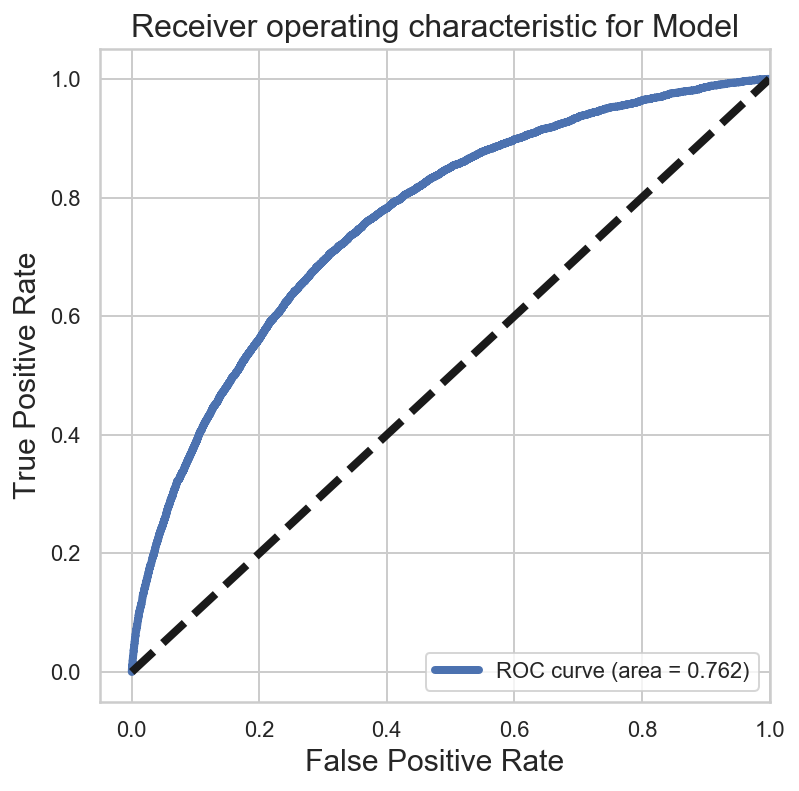

In [48]:
xgb_clf = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 n_jobs=-1,
 silent=False)


# results = results.append(benchmark(xgb_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='XGBoost max_depth=10, n_estimators=5000, learning rate=0.01'), ignore_index=True)


________________________________________________________________________________
Training: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=500,
       n_jobs=-1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)
[0]	validation_0-error:0.080725
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.080725
[2]	validation_0-error:0.080725
[3]	validation_0-error:0.080725
[4]	validation_0-error:0.080725
[5]	validation_0-error:0.080725
[6]	validation_0-error:0.080725
[7]	validation_0-error:0.080725
[8]	validation_0-error:0.080725
[9]	validation_0-error:0.080725
[10]	validation_0-error:0.080725
[11]	validation_0-error:0.080725
[12]	validation_0-error:0.080725
[13]	validation_0-error:0.080

C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on train set:  1.396s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on test set:  0.450s
accuracy:   0.919
auc_roc score for train data:   0.500
auc_roc score for test data:   0.500


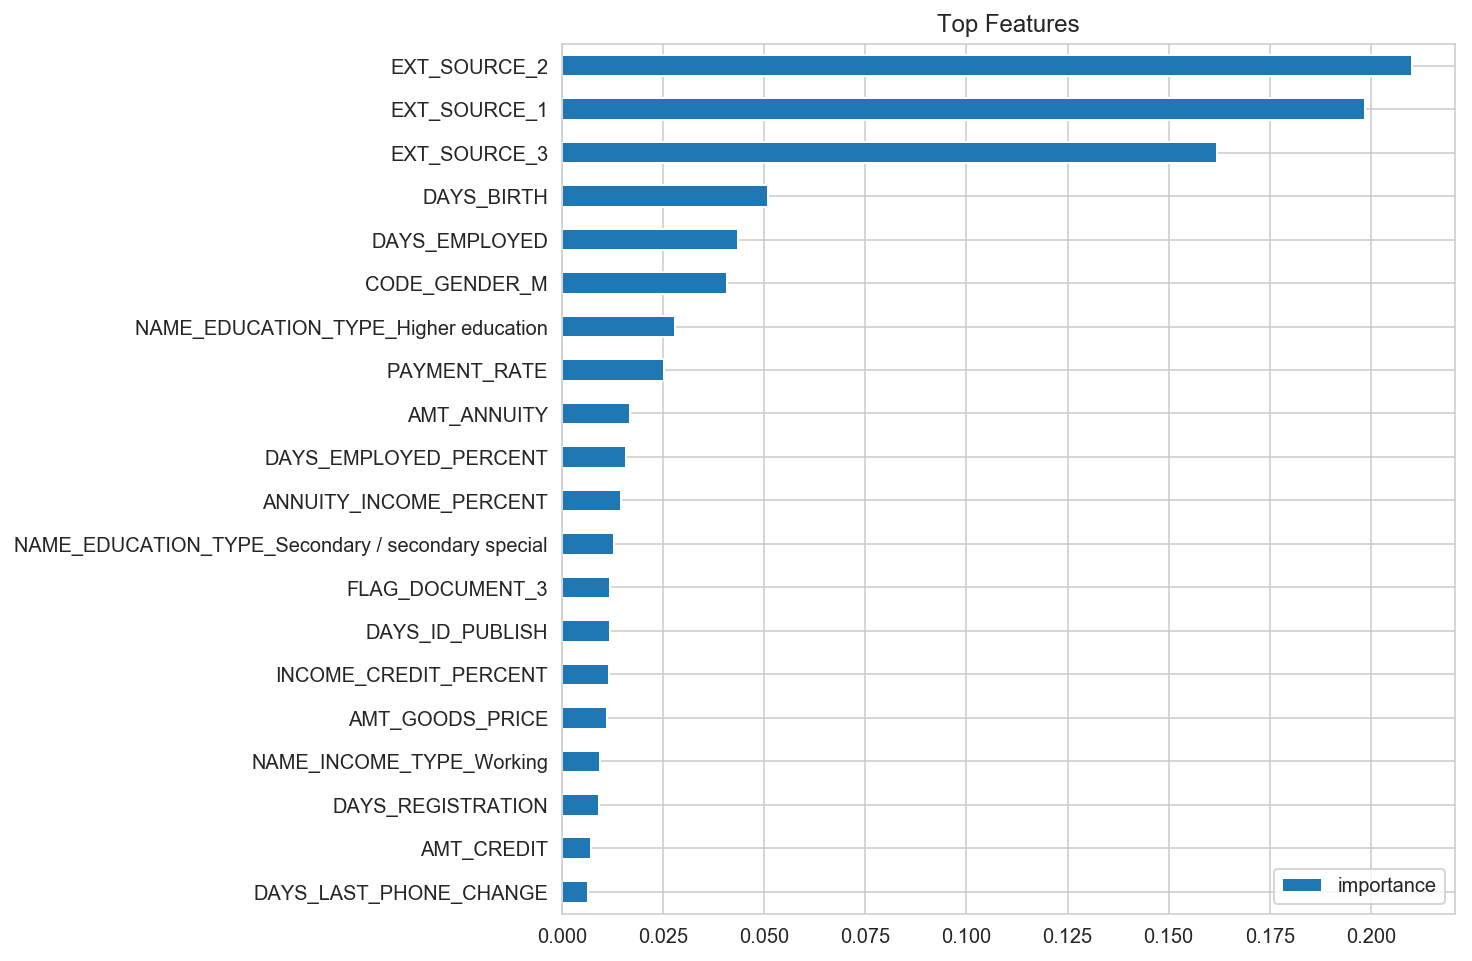

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.00      0.00      0.00      6206

avg / total       0.85      0.92      0.88     76878


Recall metric in the training dataset: 0.0
Precision metric in the training dataset: 0.91927
Confusion matrix:



C:\Users\mail\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


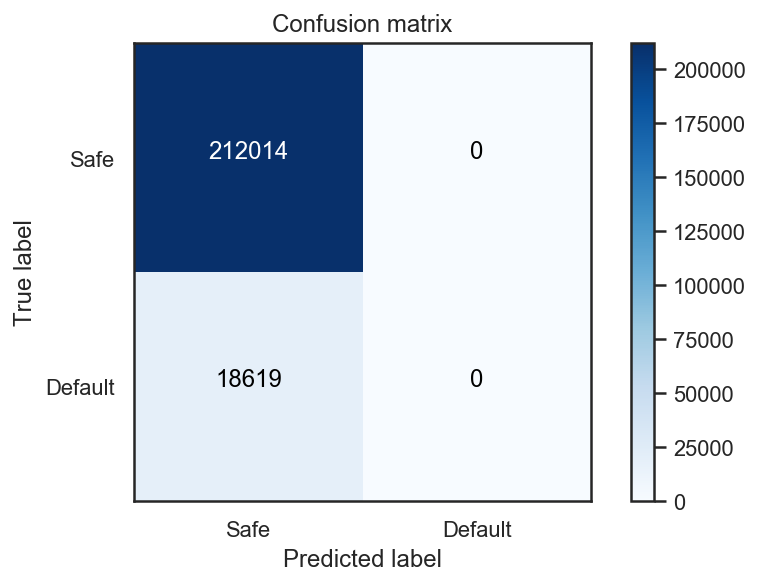


Recall metric in the testing dataset: 0.0
Precision metric in the testing dataset: 0.91927
Confusion matrix:



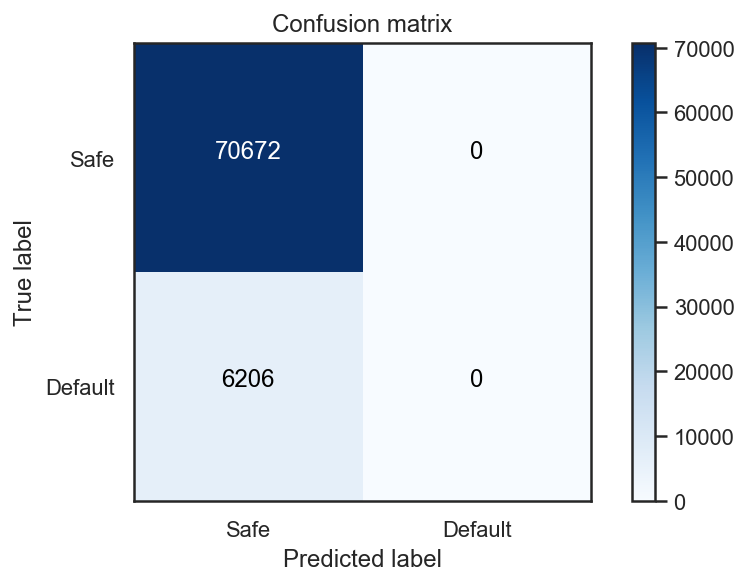


Plot roc curve:
Auc: 0.6975215763484781


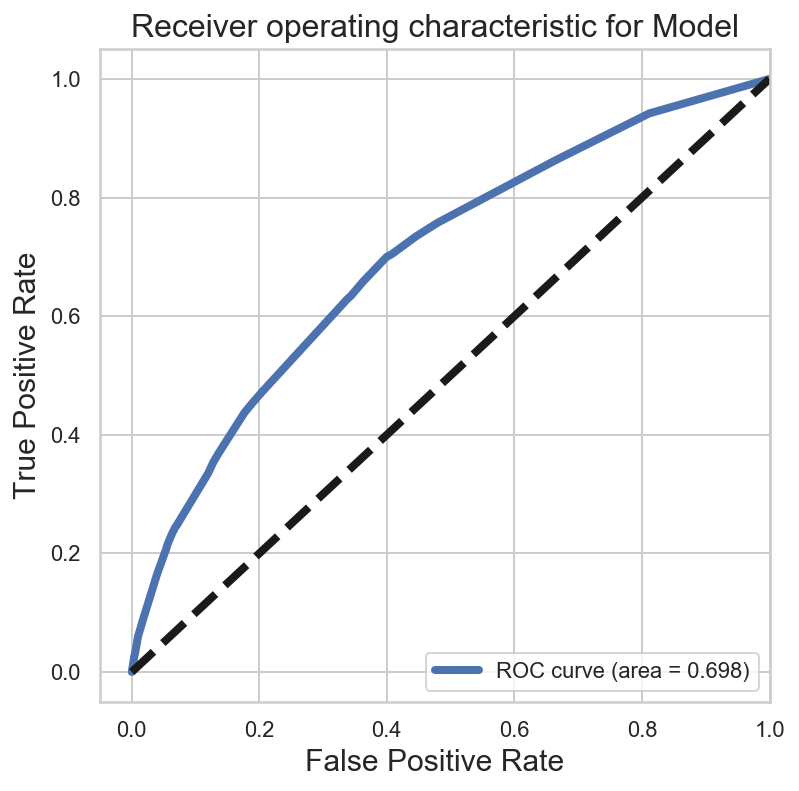

In [29]:
xgb_clf = XGBClassifier(
 learning_rate =0.02,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 n_jobs=-1,
 silent=True)

results = results.append(benchmark(xgb_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='XGBoost max_depth=5, n_estimators=500, learning rate=0.01'), ignore_index=True)

In [ ]:
# SGDClassifier with L1 to achieve gradient descent and feature selection
# parameters: 
#   penalty = 'L1' - for feature selection properties
#   random_state = 38
# Other parameters are taken from package's defaults.
sgd_clf_hinge_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False)

# SGDClassifier with elasticnet to achieve gradient descent
# parameters: 
#   penalty = 'elasticnet' - elasticnet
#   random_state = 38
# The other parameters is taken from package default
sgd_clf_hinge_elastic_net = SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False)

sgd_clf_hinge_balanced_elastic_net = SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False, class_weight='balanced')

# SGDClassifier with elasticnet to achieve gradient descent
# parameters: 
#   penalty = 'elasticnet' - elasticnet
#   random_state = 38
# The other parameters is taken from package default
sgd_clf_log_elastic_net = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False)

sgd_clf_log_balanced_elastic_net = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False, class_weight='balanced')
 

### SVM

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 15.938s
cross validation Score: 0.916 ± 0.006
test time on train set:  0.323s
test time on test set:  0.151s
accuracy:   0.919
auc_roc score for train data:   0.500
auc_roc score for test data:   0.500
dimensionality: 233
top 10 keywords per class:


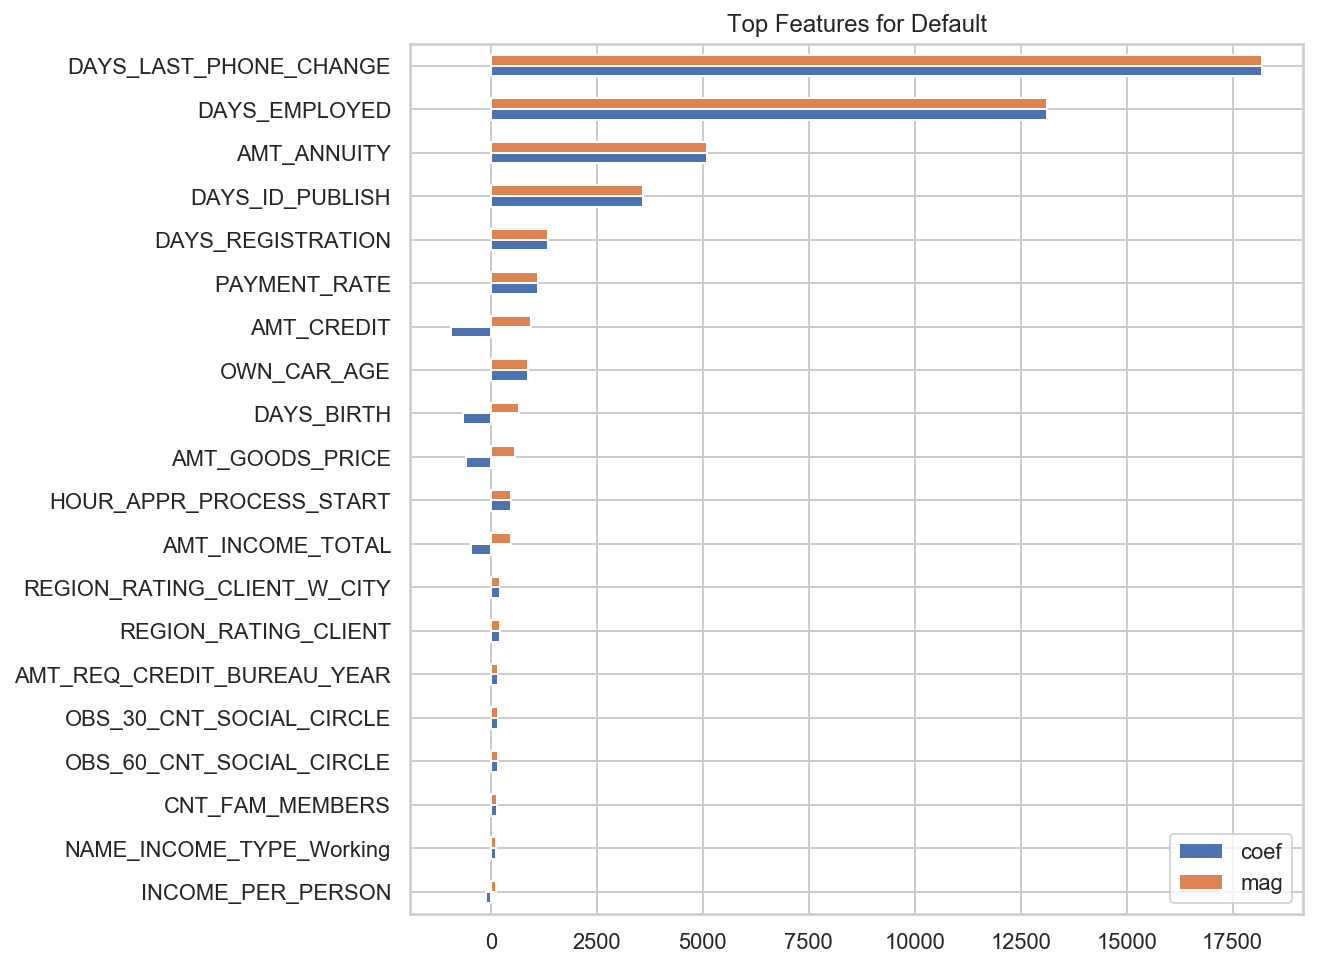

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.00      0.00      0.00      6206

avg / total       0.85      0.92      0.88     76878


Recall metric in the training dataset: 0.0
Precision metric in the training dataset: 0.91927
Confusion matrix:



C:\Users\mail\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


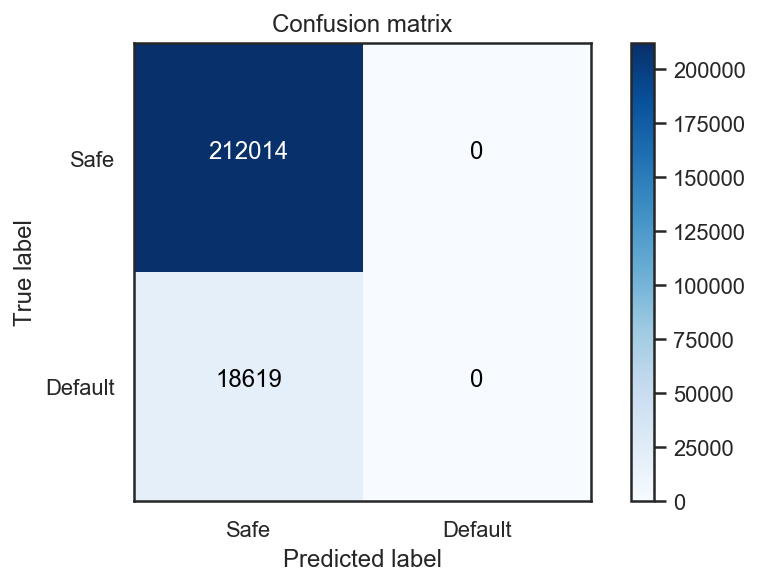


Recall metric in the testing dataset: 0.0
Precision metric in the testing dataset: 0.91927
Confusion matrix:



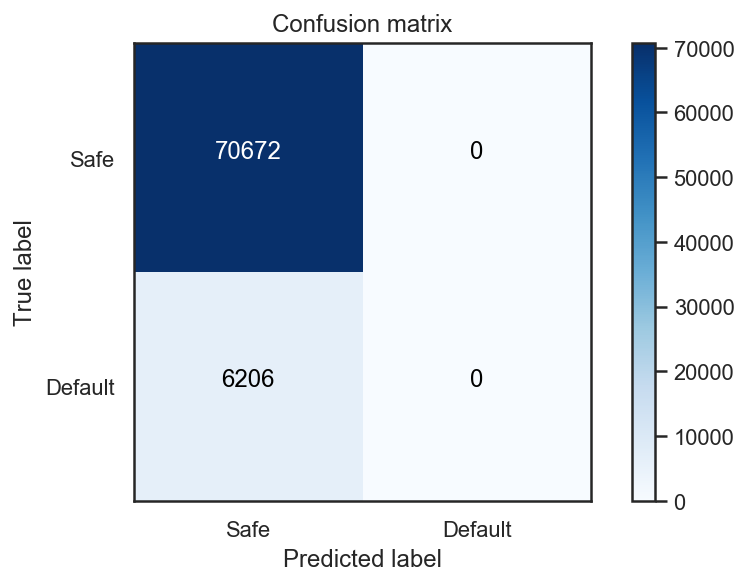


Plot roc curve:


AttributeError: probability estimates are not available for loss='hinge'

In [33]:
results = results.append(benchmark(sgd_clf_hinge_elastic_net, X_train, y_train, X_test, y_test, target_class ,feature_description='SGD hinge elastic net'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 3.430s
cross validation Score: 0.918 ± 0.001
test time on train set:  0.106s
test time on test set:  0.045s
accuracy:   0.919
auc_roc score for train data:   0.500
auc_roc score for test data:   0.500
dimensionality: 233
top 10 keywords per class:


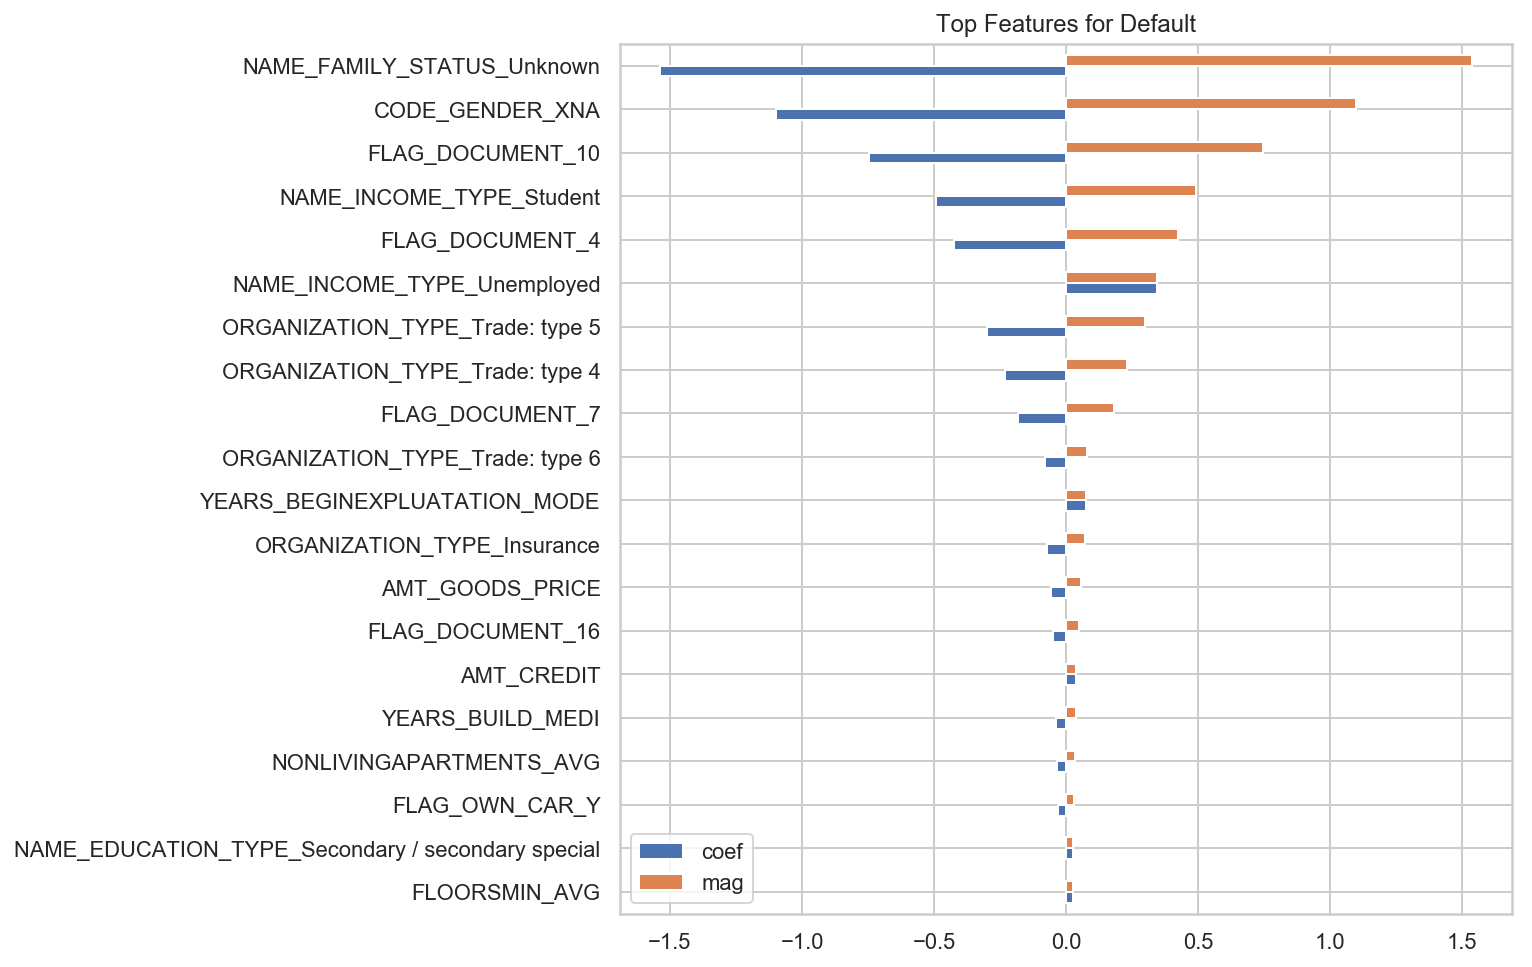

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.33      0.00      0.00      6206

avg / total       0.87      0.92      0.88     76878


Recall metric in the training dataset: 0.00032225
Precision metric in the training dataset: 0.91929
Confusion matrix:



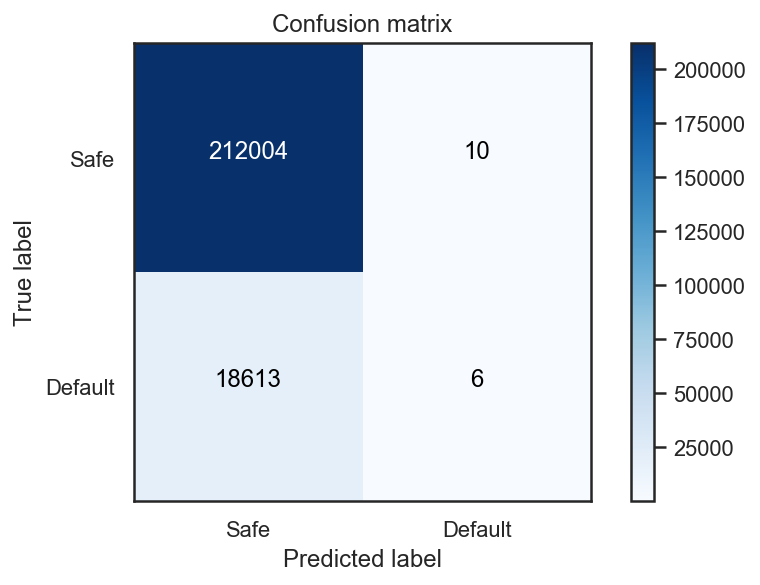


Recall metric in the testing dataset: 0.00032227
Precision metric in the testing dataset: 0.91929
Confusion matrix:



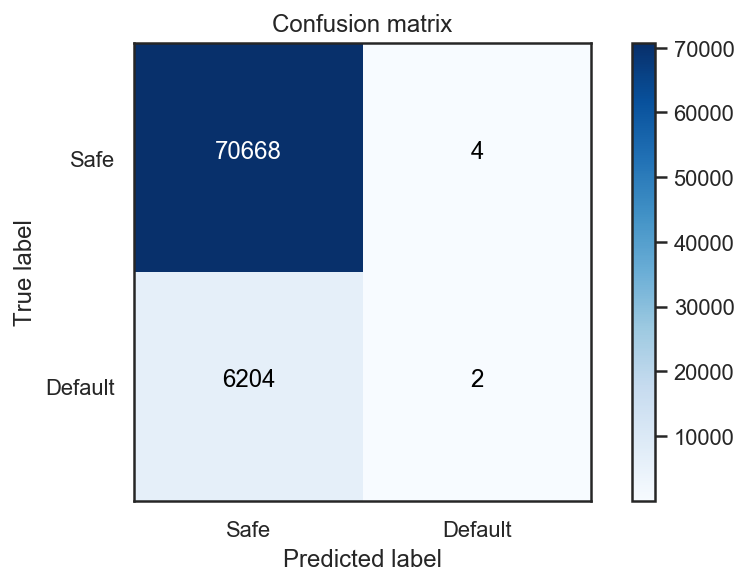


Plot roc curve:


AttributeError: probability estimates are not available for loss='hinge'

In [39]:
results = results.append(benchmark(sgd_clf_hinge_elastic_net, X_train_s, y_train, X_test_s, y_test, target_class ,feature_description='SGD hinge elastic net'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 2.835s
cross validation Score: 0.918 ± 0.001
test time on train set:  0.104s
test time on test set:  0.052s
accuracy:   0.917
auc_roc score for train data:   0.514
auc_roc score for test data:   0.514
dimensionality: 233
top 10 keywords per class:


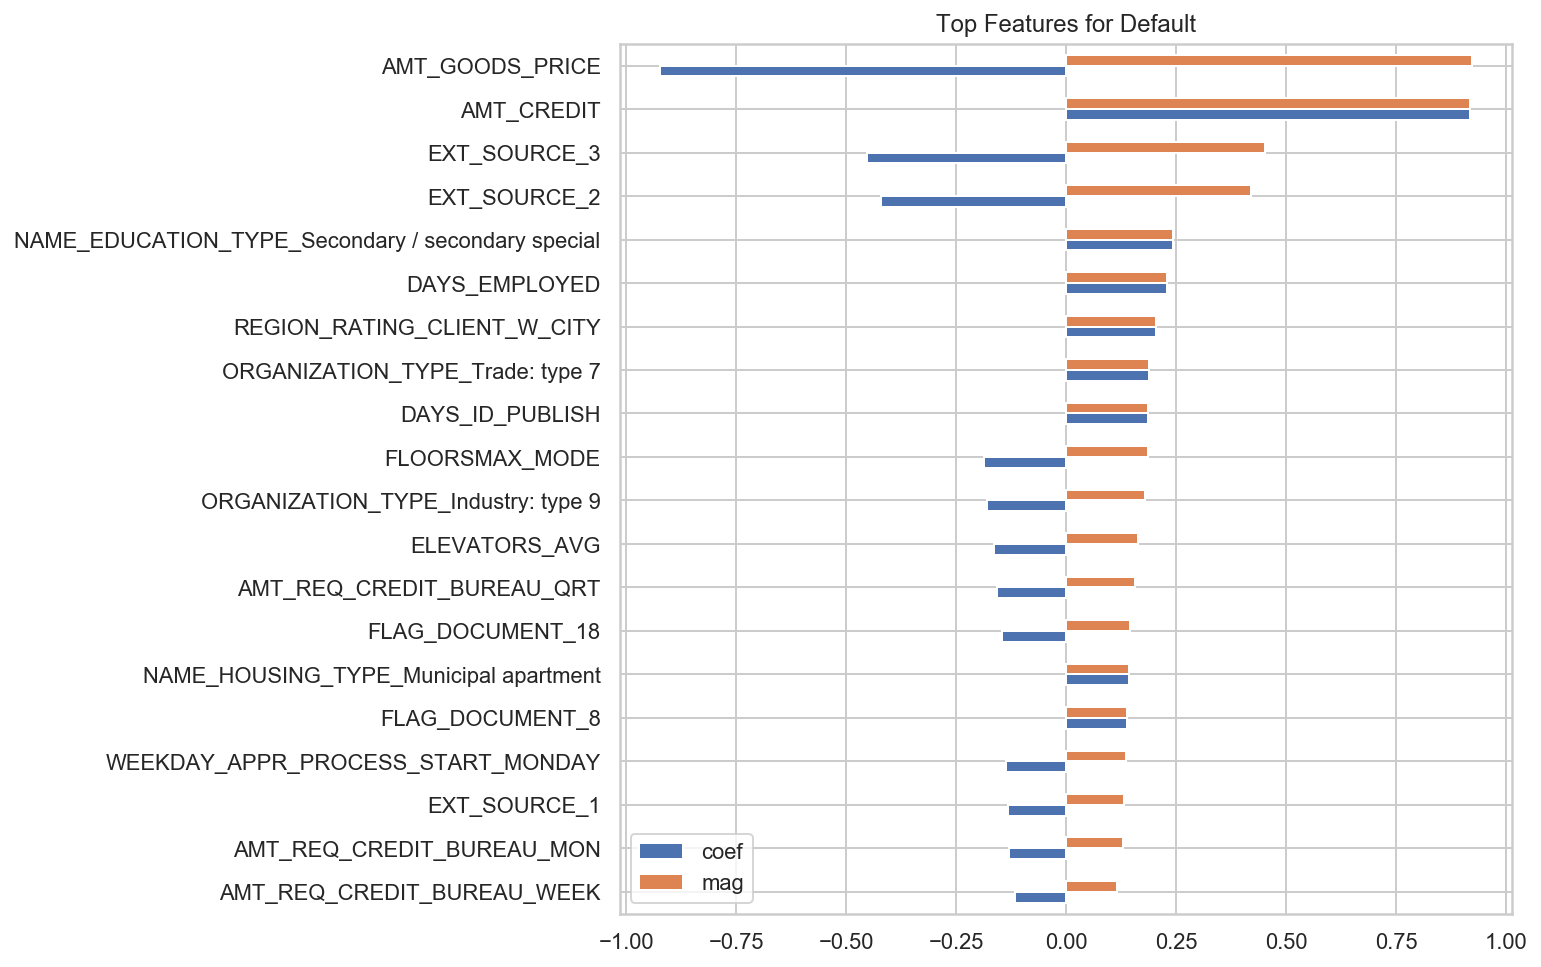

classification report on test:
             precision    recall  f1-score   support

       Safe       0.92      1.00      0.96     70672
    Default       0.37      0.03      0.06      6206

avg / total       0.88      0.92      0.88     76878


Recall metric in the training dataset: 0.032064
Precision metric in the training dataset: 0.9213
Confusion matrix:



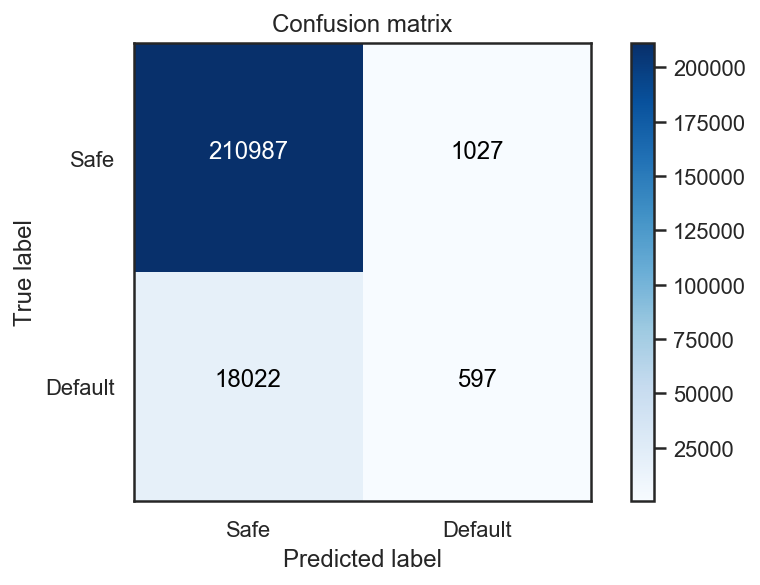


Recall metric in the testing dataset: 0.032066
Precision metric in the testing dataset: 0.92131
Confusion matrix:



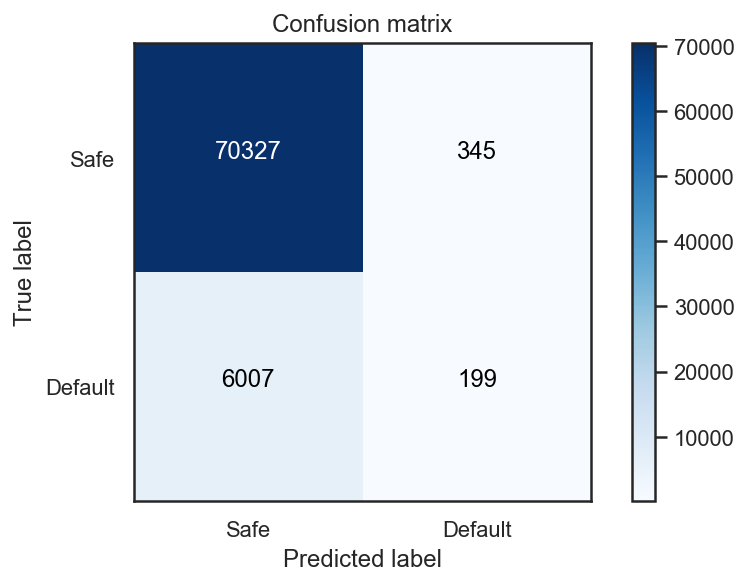


Plot roc curve:
Auc: 0.7098630186259969


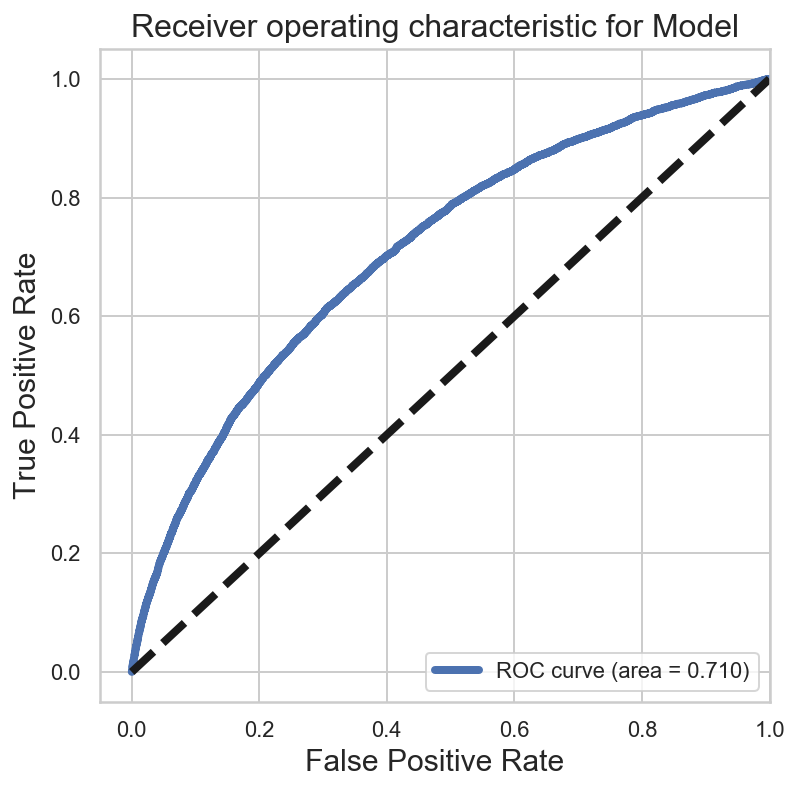

In [40]:
results = results.append(benchmark(sgd_clf_log_elastic_net, X_train_s, y_train, X_test_s, y_test, target_class ,feature_description='SGD log elastic net'), ignore_index=True)

### Logistic Regression

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 6.416s
cross validation Score: 0.661 ± 0.016
test time on train set:  0.102s
test time on test set:  0.056s
accuracy:   0.625
auc_roc score for train data:   0.654
auc_roc score for test data:   0.644
dimensionality: 233
top 10 keywords per class:


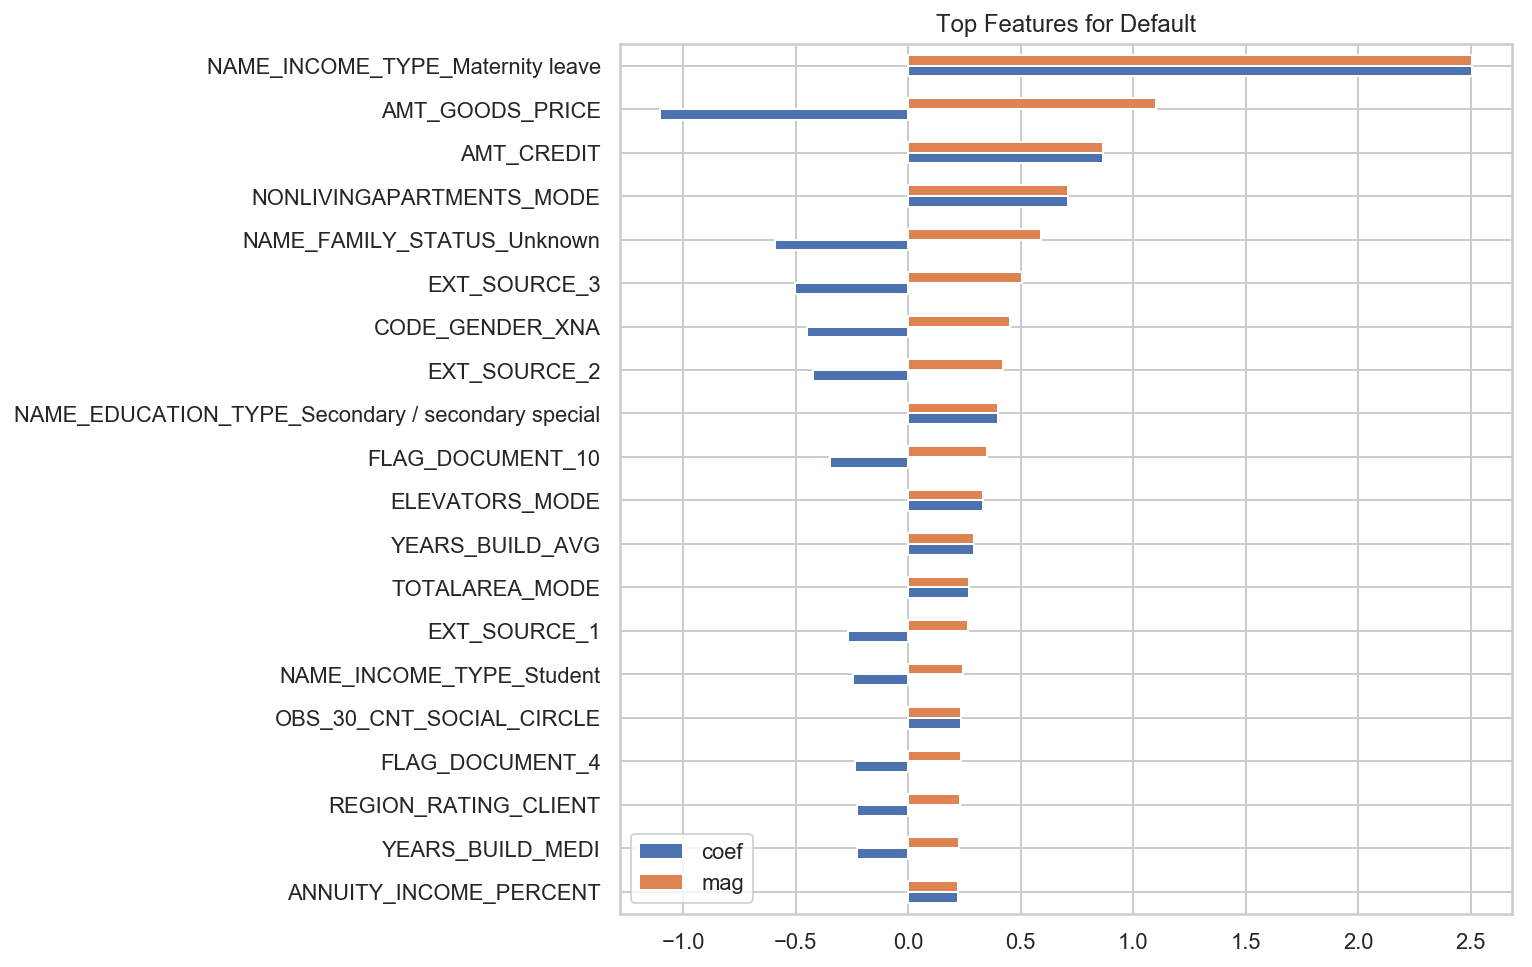

classification report on test:
             precision    recall  f1-score   support

       Safe       0.96      0.62      0.75     70672
    Default       0.13      0.67      0.22      6206

avg / total       0.89      0.63      0.71     76878


Recall metric in the training dataset: 0.68559
Precision metric in the training dataset: 0.95748
Confusion matrix:



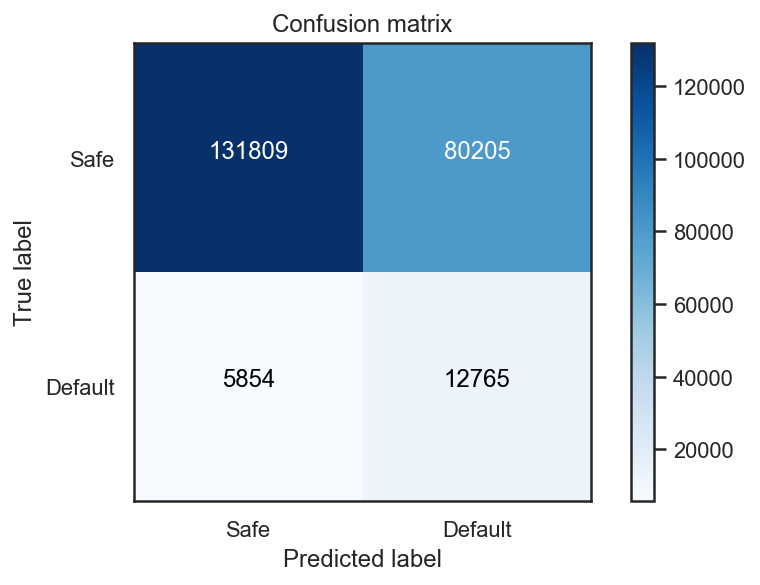


Recall metric in the testing dataset: 0.66677
Precision metric in the testing dataset: 0.95503
Confusion matrix:



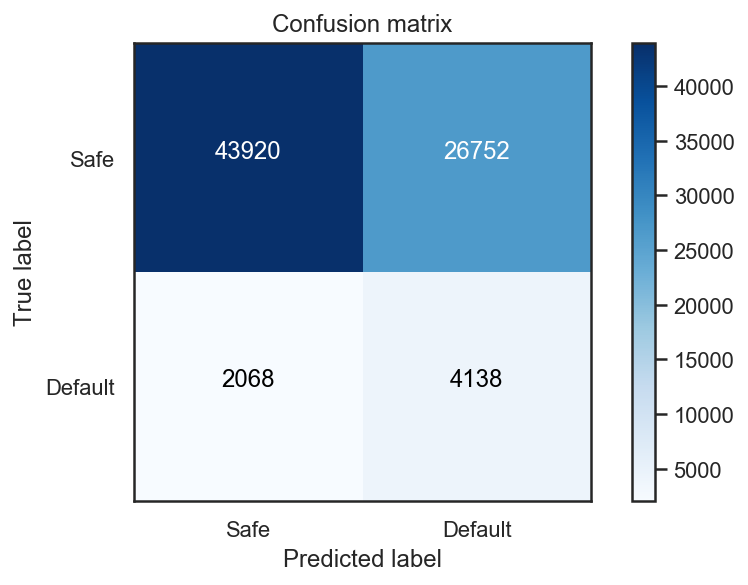


Plot roc curve:
Auc: 0.6929004905879934


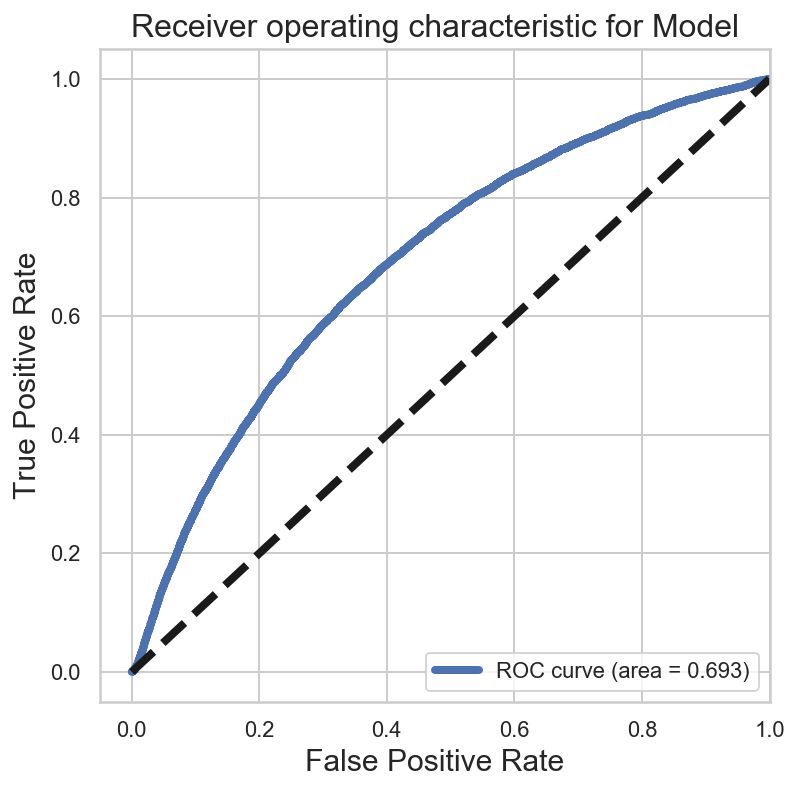

In [43]:
results = results.append(benchmark(sgd_clf_log_balanced_elastic_net, X_train_s, y_train, X_test_s, y_test, target_class ,feature_description='SGD log elastic net'), ignore_index=True)

## LIGHTGBM

________________________________________________________________________________
Training: 
LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=38, reg_alpha=0.436193,
        reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)
Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.235413	training's auc: 0.806162
[800]	training's binary_logloss: 0.221747	training's auc: 0.835257
[1200]	training's binary_logloss: 0.212536	training's auc: 0.855437
[1600]	training's binary_logloss: 0.204877	training's auc: 0.872445
[2000]	training's binary_logloss: 0.198082	training's auc: 0.887266
[24

C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on train set:  545.663s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on test set:  183.542s
accuracy:   0.921
auc_roc score for train data:   0.714
auc_roc score for test data:   0.526


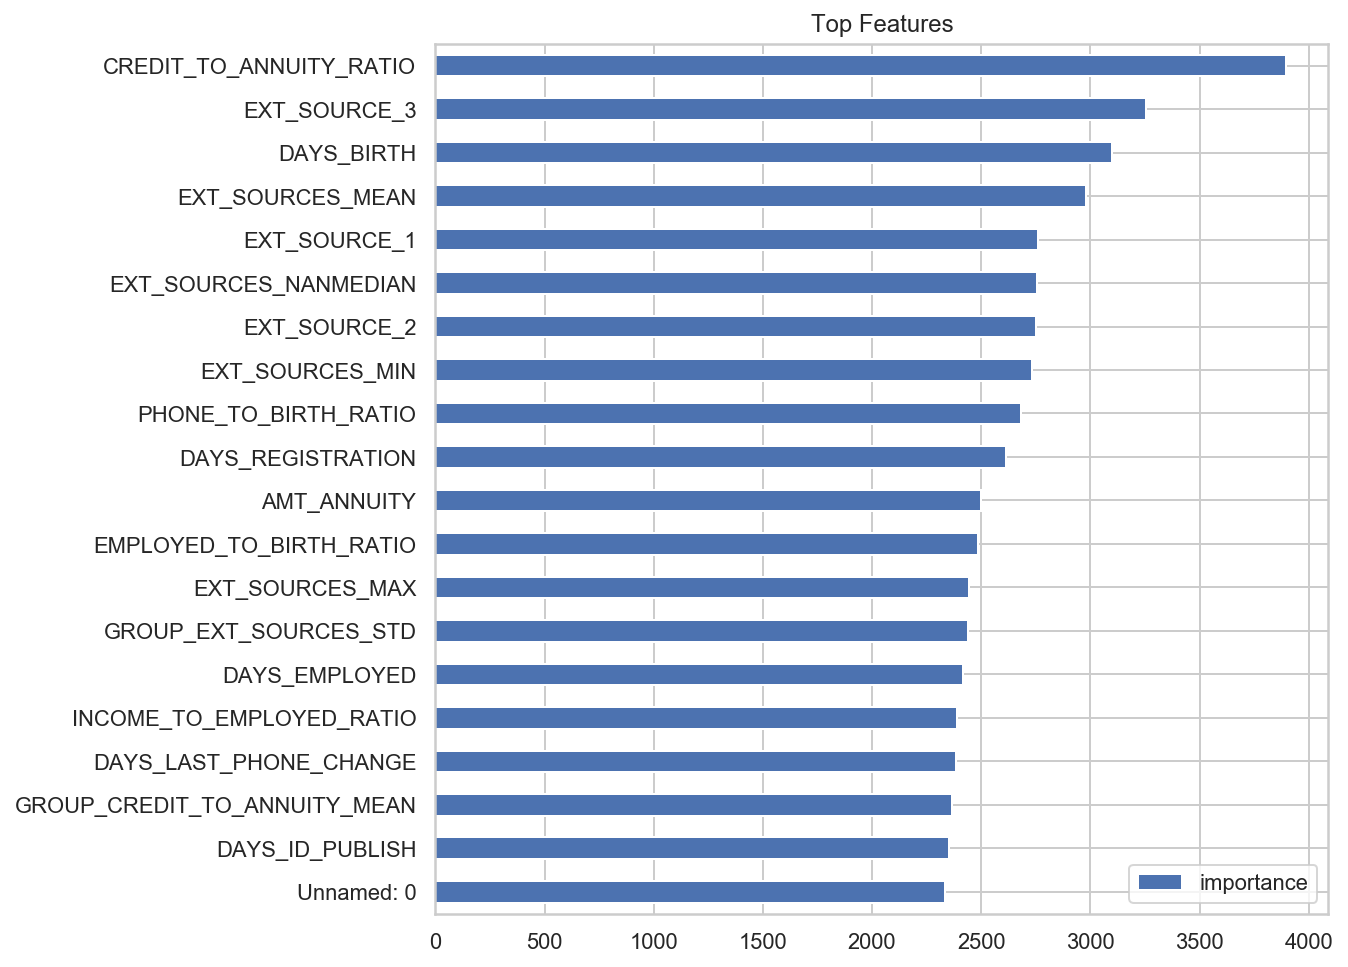

classification report on test:
             precision    recall  f1-score   support

       Good       0.92      1.00      0.96     70671
        Bad       0.58      0.05      0.10      6206

avg / total       0.90      0.92      0.89     76877


Recall metric in the training dataset: 0.42754
Precision metric in the training dataset: 0.95212
Confusion matrix:



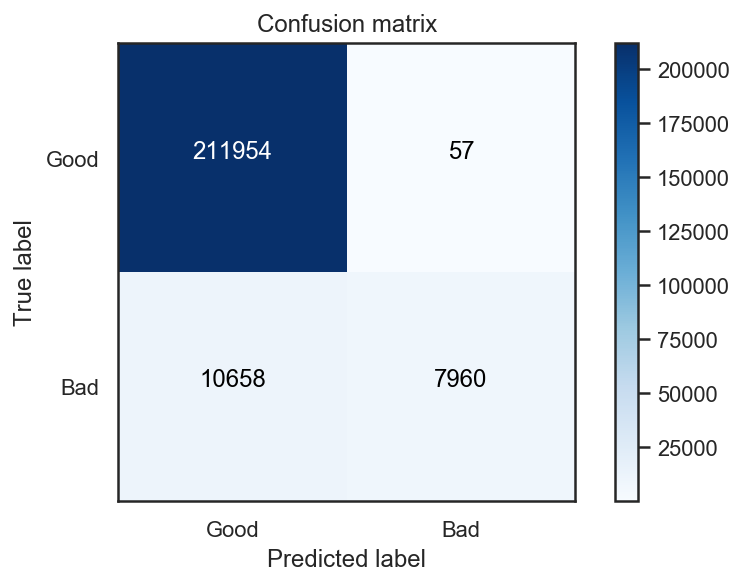


Recall metric in the testing dataset: 0.054947
Precision metric in the testing dataset: 0.92313
Confusion matrix:



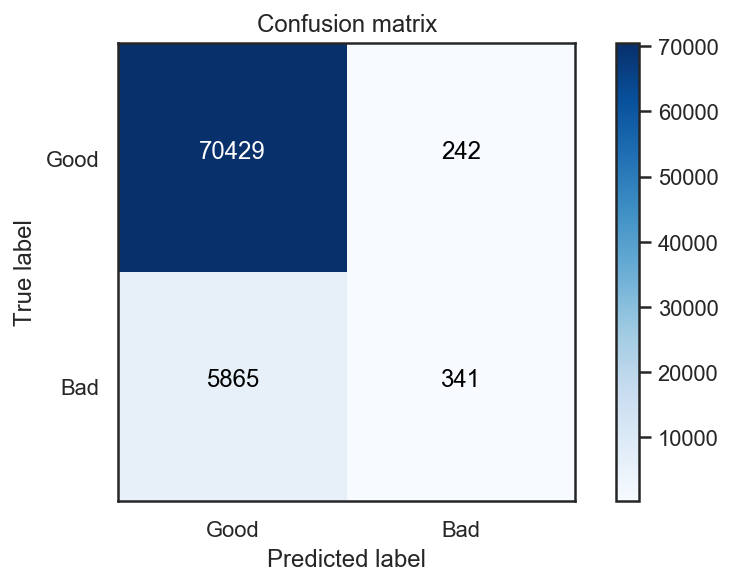


Plot roc curve:
Auc: 0.7937695552233563


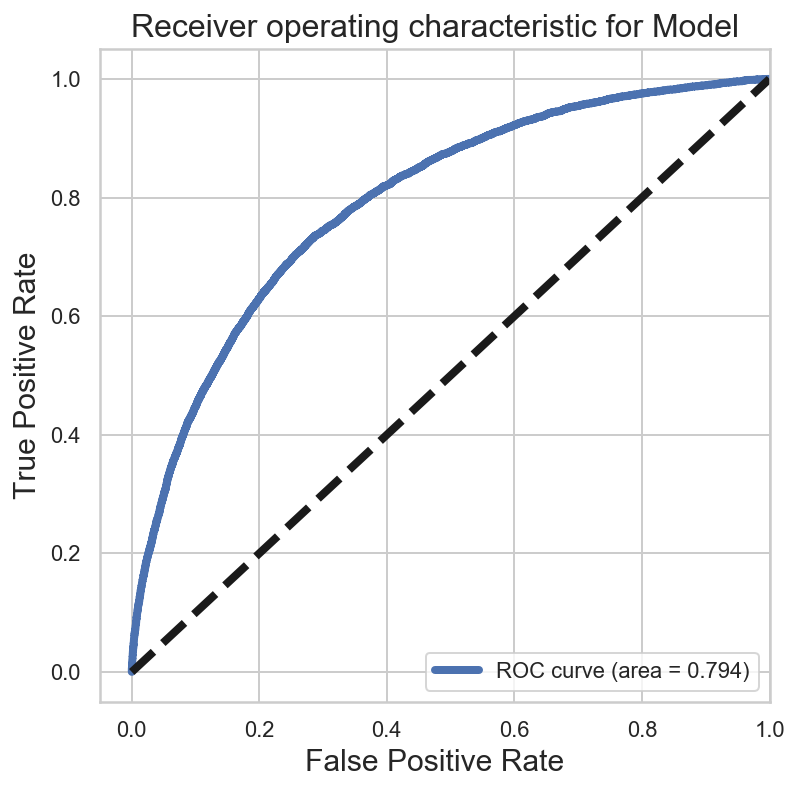

In [13]:
EARLY_STOPPING = 100
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

params = {'random_state': 38, 'nthread': 4}
lgbm_clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM', to_cross_validate=False), ignore_index=True)

In [ ]:
params = {'random_state': 38, 'nthread': 4}
lgbm_clf_cv = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf_cv, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM', to_cross_validate=True), ignore_index=True)

________________________________________________________________________________
Training: 
LGBMClassifier(boosting_type='goss', class_weight='balanced',
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=38, reg_alpha=0.436193,
        reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)
Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.561758	training's auc: 0.801637
[800]	training's binary_logloss: 0.52331	training's auc: 0.828703
[1200]	training's binary_logloss: 0.498342	training's auc: 0.847734
[1600]	training's binary_logloss: 0.478197	training's auc: 0.863623
[2000]	training's binary_logloss: 0.460893	training's auc: 0.87748

C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on train set:  566.530s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on test set:  192.128s
accuracy:   0.842
auc_roc score for train data:   0.943
auc_roc score for test data:   0.687


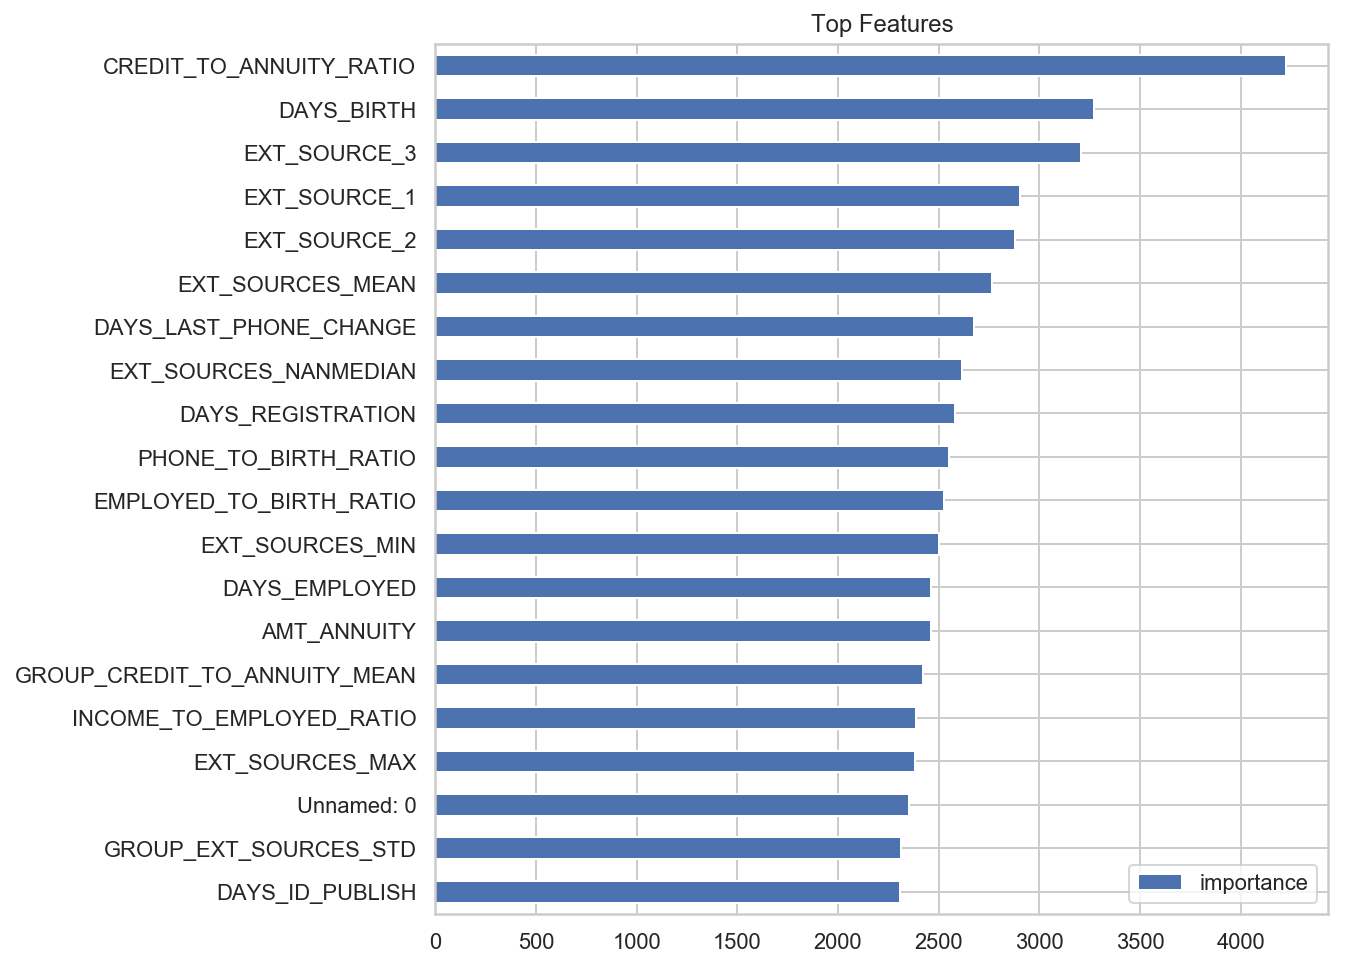

classification report on test:
             precision    recall  f1-score   support

       Good       0.95      0.87      0.91     70671
        Bad       0.26      0.50      0.34      6206

avg / total       0.90      0.84      0.86     76877


Recall metric in the training dataset: 0.97948
Precision metric in the training dataset: 0.99802
Confusion matrix:



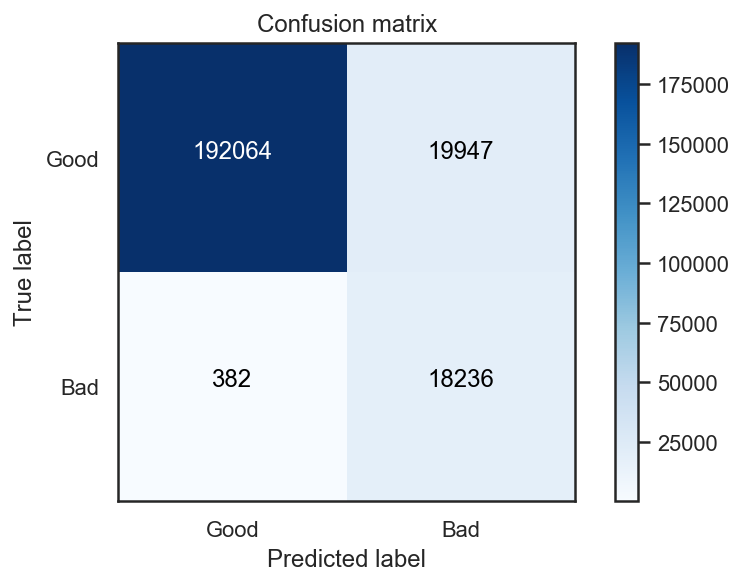


Recall metric in the testing dataset: 0.50242
Precision metric in the testing dataset: 0.95227
Confusion matrix:



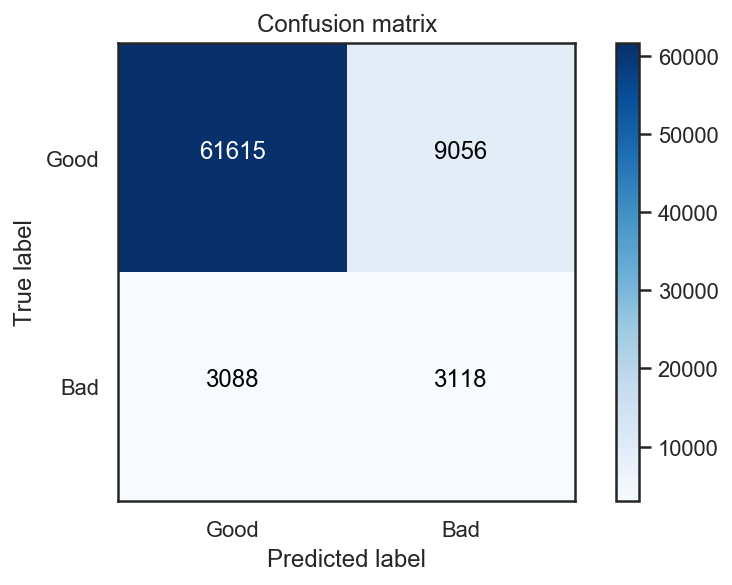


Plot roc curve:
Auc: 0.7903307242974125


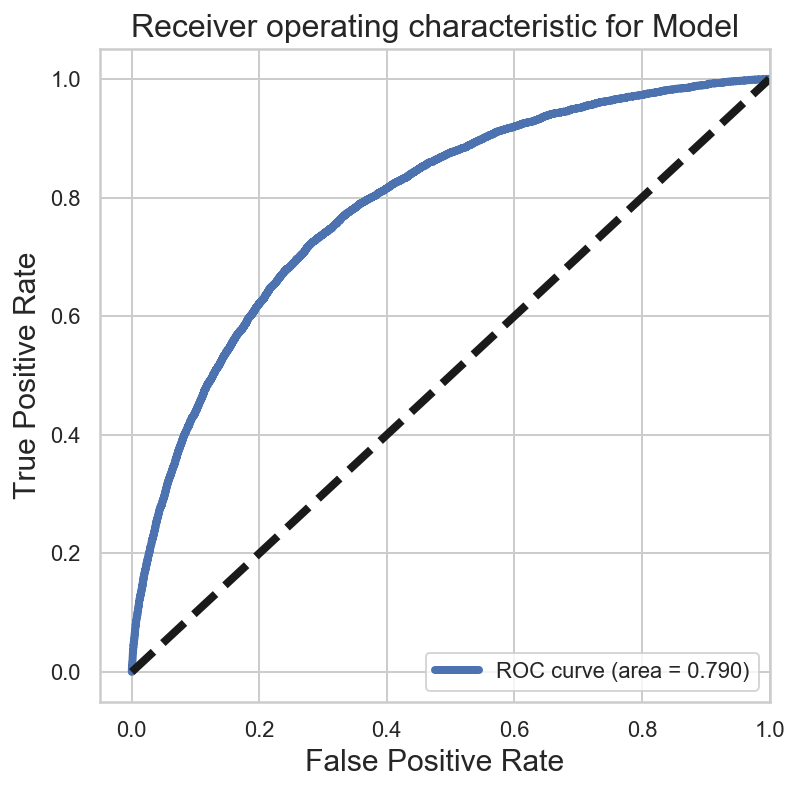

In [14]:
EARLY_STOPPING = 100
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'class_weight': 'balanced',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

params = {'random_state': 38, 'nthread': 4}
lgbm_clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM_balanced',to_cross_validate=False), ignore_index=True)

________________________________________________________________________________
Training: 
LGBMClassifier(boosting_type='goss', class_weight='balanced',
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=6,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=38, reg_alpha=0.436193,
        reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)
Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.565782	training's auc: 0.79755
[800]	training's binary_logloss: 0.530484	training's auc: 0.823442
[1200]	training's binary_logloss: 0.509142	training's auc: 0.839859
[1600]	training's binary_logloss: 0.492987	training's auc: 0.852537
[2000]	training's binary_logloss: 0.479371	training's auc: 0.863347

C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on train set:  153.407s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


test time on test set:  50.099s
accuracy:   0.820
auc_roc score for train data:   0.905
auc_roc score for test data:   0.697


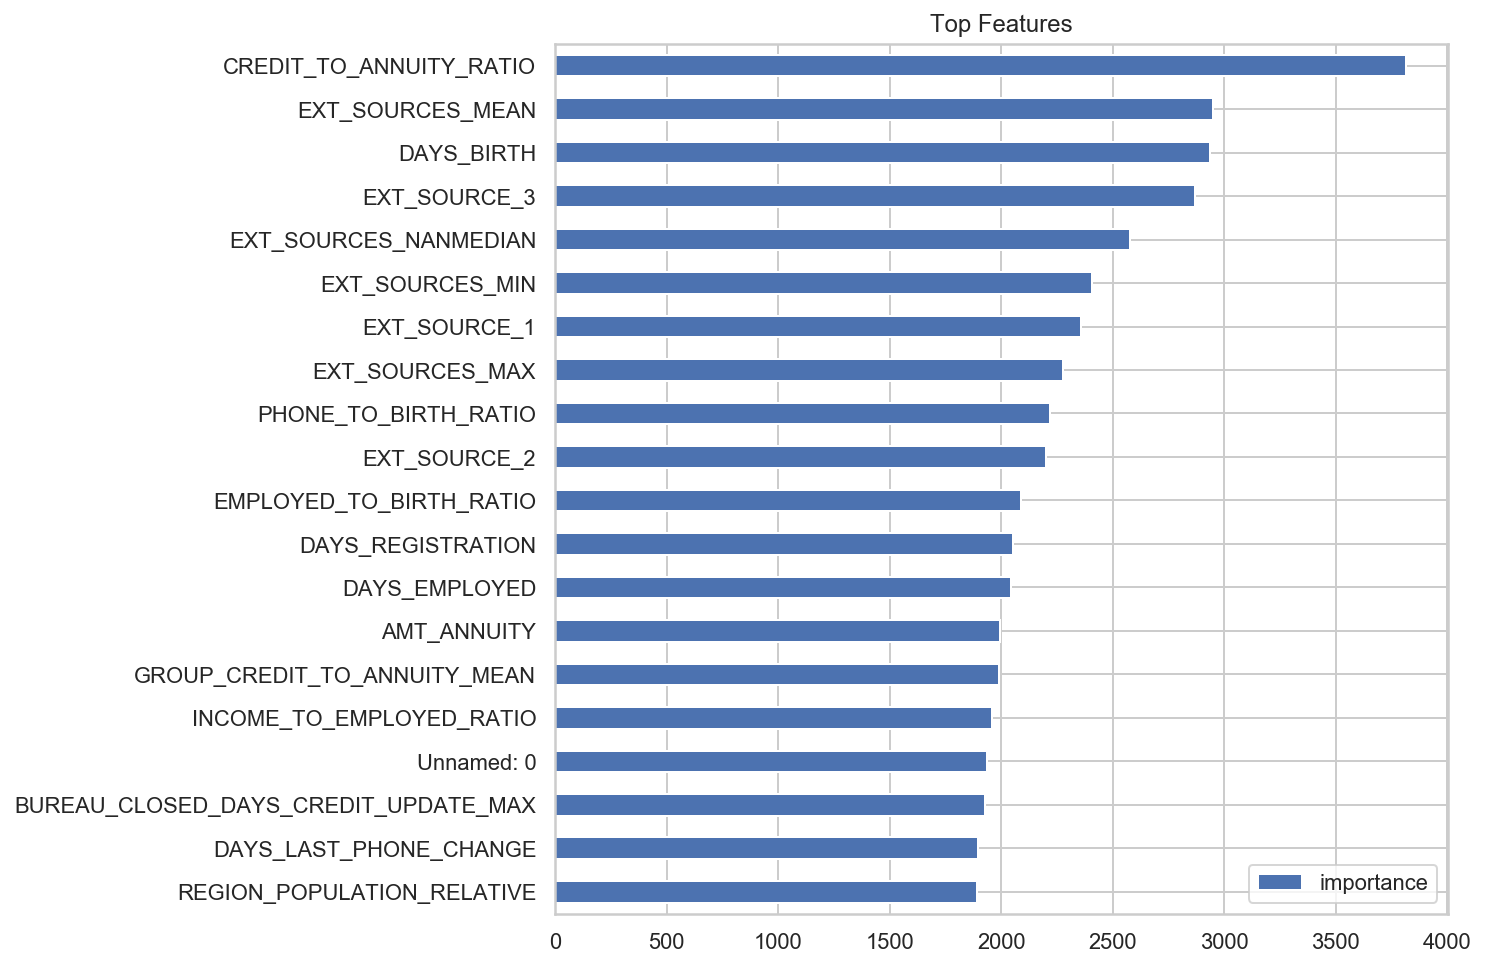

classification report on test:
             precision    recall  f1-score   support

       Good       0.96      0.84      0.90     70671
        Bad       0.24      0.55      0.33      6206

avg / total       0.90      0.82      0.85     76877


Recall metric in the training dataset: 0.93732
Precision metric in the training dataset: 0.99373
Confusion matrix:



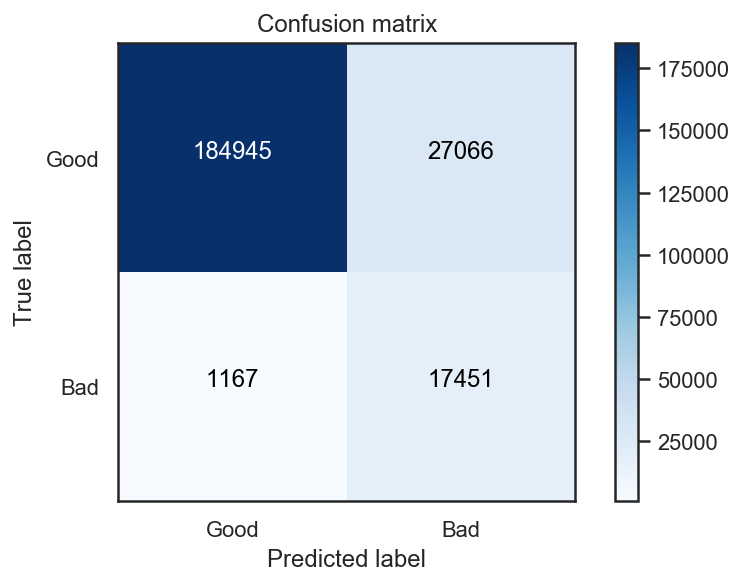


Recall metric in the testing dataset: 0.55108
Precision metric in the testing dataset: 0.95536
Confusion matrix:



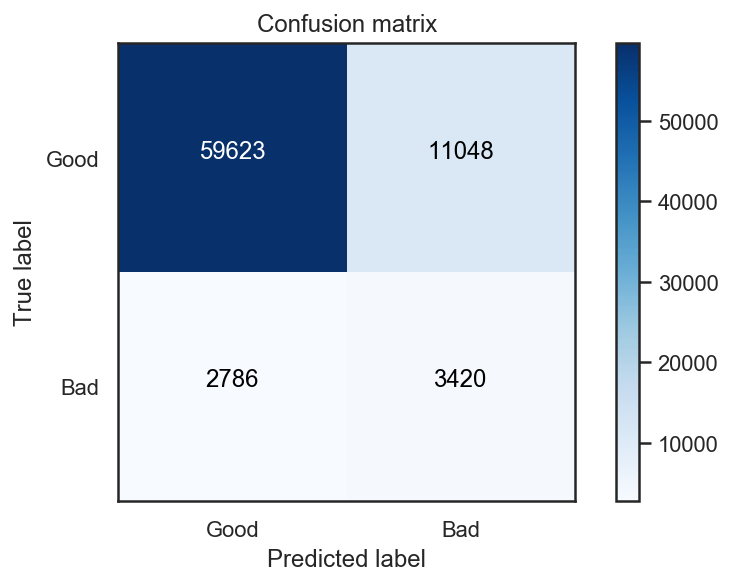


Plot roc curve:
Auc: 0.7897316740251392


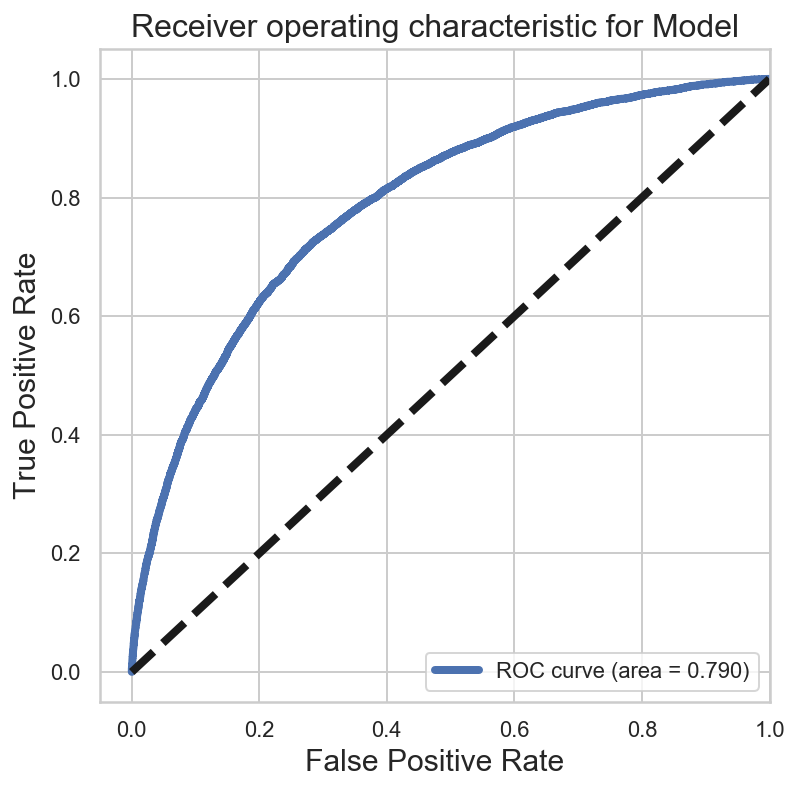

In [15]:
EARLY_STOPPING = 100
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'class_weight': 'balanced',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 6,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

params = {'random_state': 38, 'nthread': 4}
lgbm_clf_max6 = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf_max6, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM_balanced',to_cross_validate=False), ignore_index=True)

________________________________________________________________________________
Training: 
LGBMClassifier(boosting_type='goss', class_weight='balanced',
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=4,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=38, reg_alpha=0.436193,
        reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)
Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.766415	training's binary_logloss: 0.590246
[800]	training's auc: 0.787833	training's binary_logloss: 0.564733
[1200]	training's auc: 0.799093	training's binary_logloss: 0.55084
[1600]	training's auc: 0.806809	training's binary_logloss: 0.541302
[2000]	training's auc: 0.813097	training's binary_logloss: 0.533614

C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unique_values = np.unique(values)


test time on train set:  99.671s


C:\Users\mail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unique_values = np.unique(values)


test time on test set:  33.158s
accuracy:   0.766
auc_roc score for train data:   0.797
auc_roc score for test data:   0.717


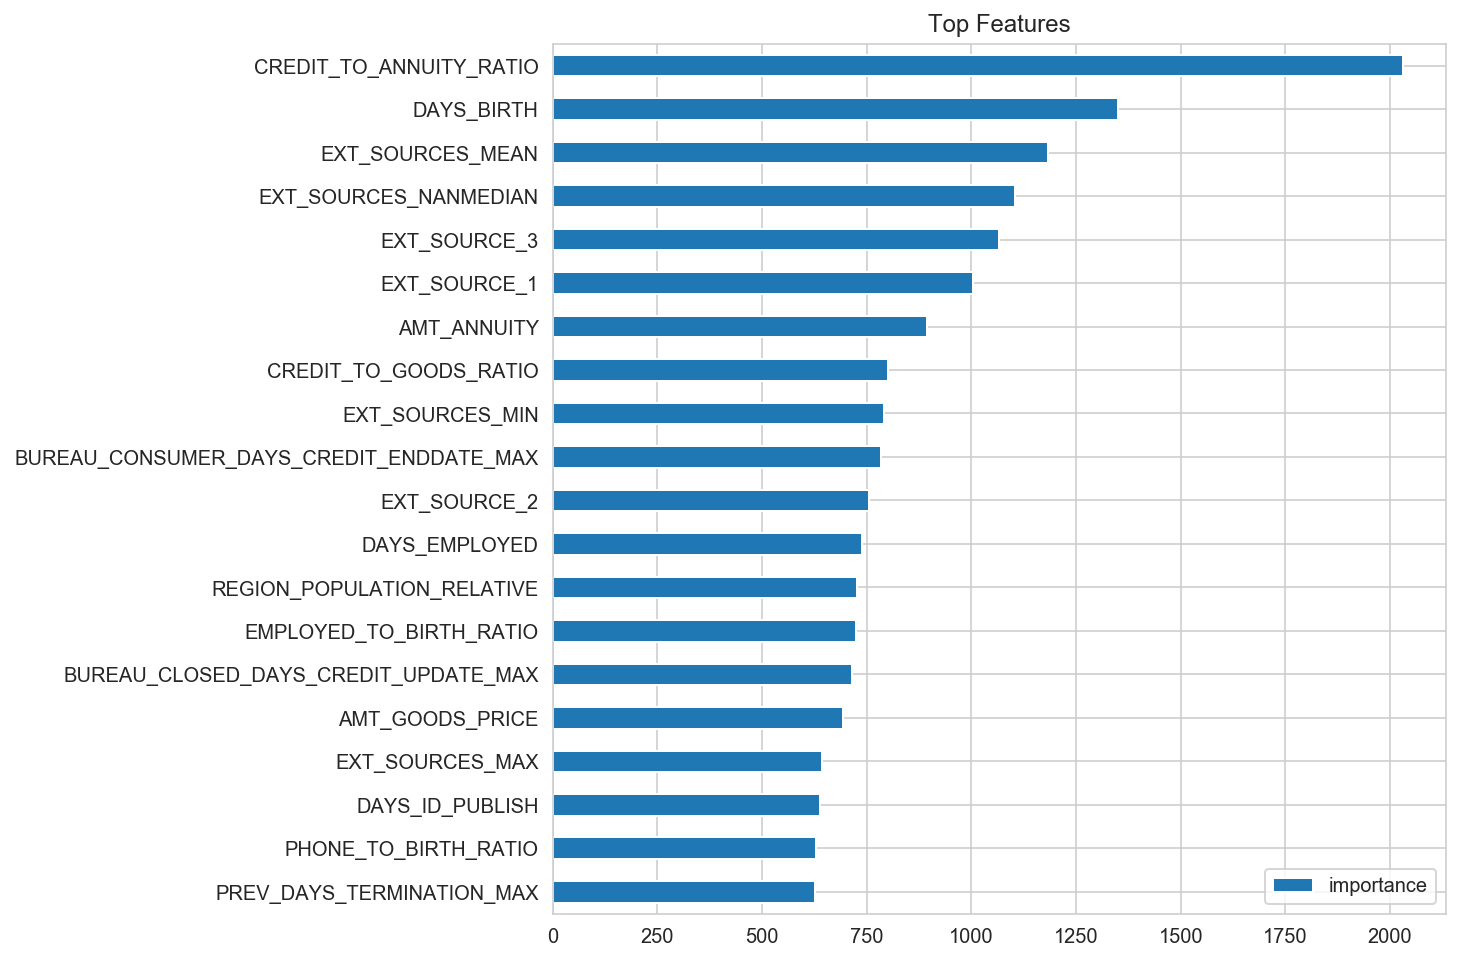

classification report on test:
             precision    recall  f1-score   support

       Good       0.96      0.78      0.86     70671
        Bad       0.20      0.66      0.31      6206

avg / total       0.90      0.77      0.81     76877


Recall metric in the training dataset: 0.80932
Precision metric in the training dataset: 0.97913
Confusion matrix:



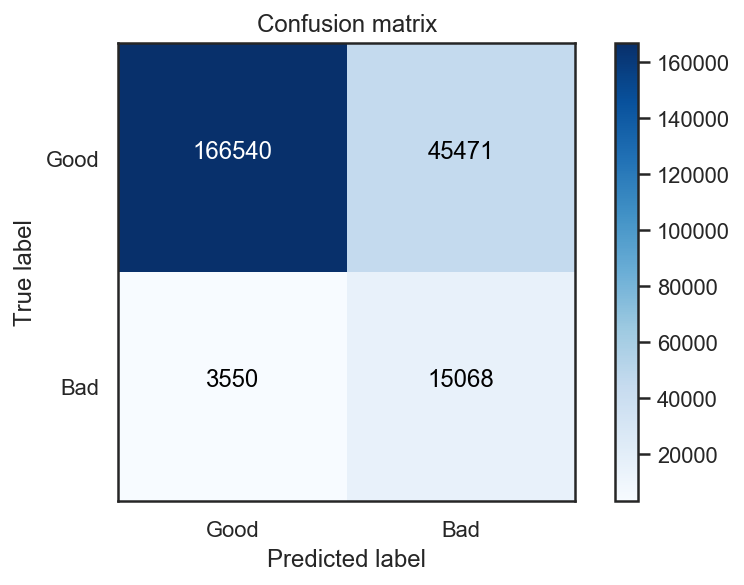


Recall metric in the testing dataset: 0.65936
Precision metric in the testing dataset: 0.96285
Confusion matrix:



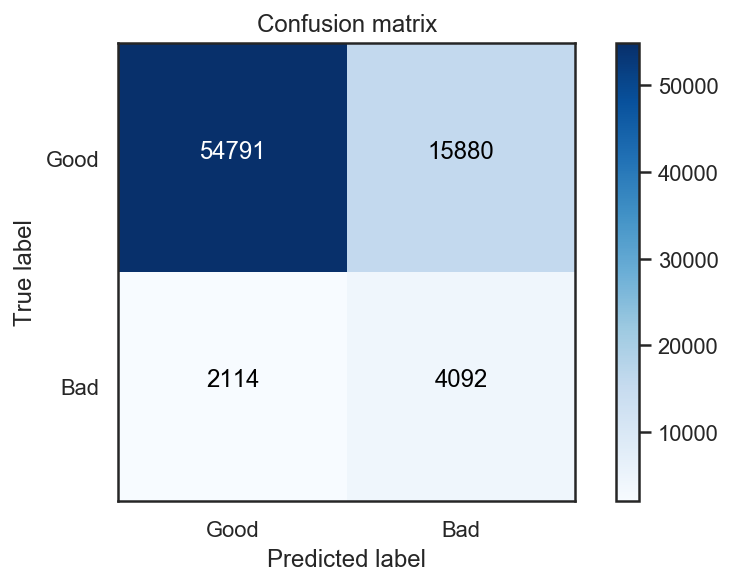


Plot roc curve:
Auc: 0.7929109880937669


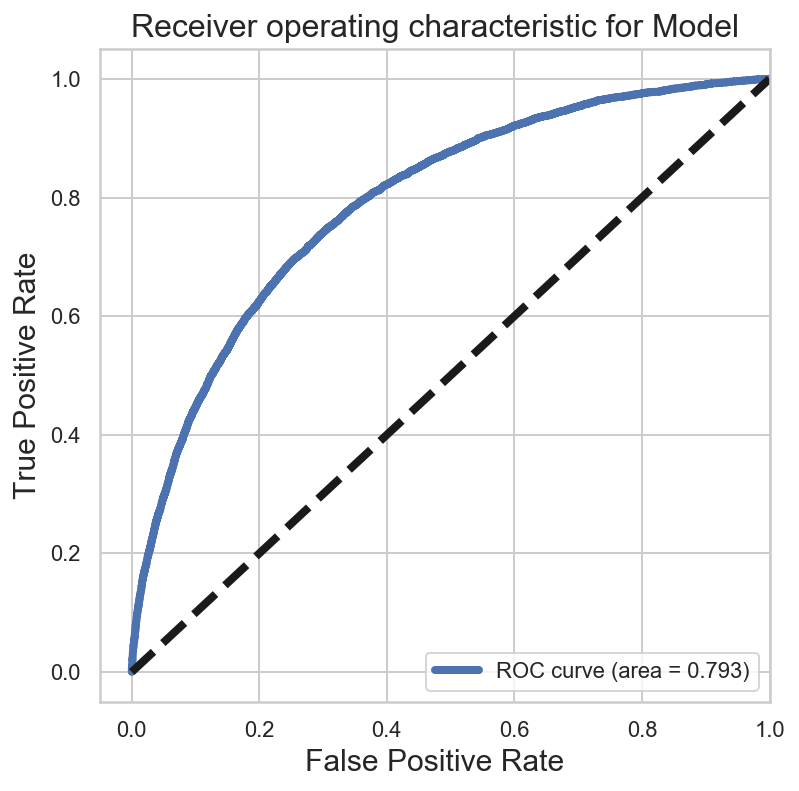

In [16]:
EARLY_STOPPING = 100
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'class_weight': 'balanced',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 4,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

params = {'random_state': 38, 'nthread': 4}
lgbm_clf_max4 = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf_max4, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM_balanced',to_cross_validate=False), ignore_index=True)

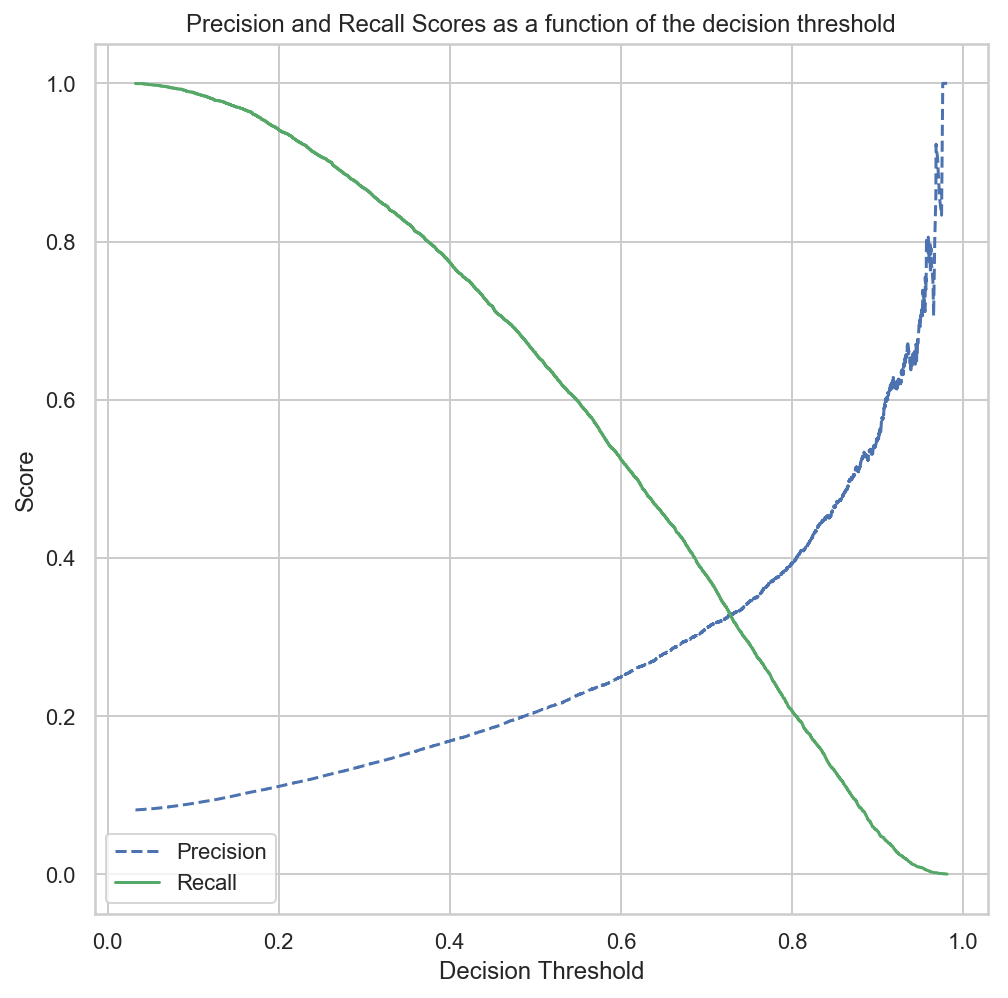

In [20]:
y_scores = lgbm_clf_max4.predict_proba(X_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
EARLY_STOPPING = 100
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
#    'class_weight': 'balanced',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 4,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

params = {'random_state': 38, 'nthread': 4}
lgbm_clf_max4 = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})

results = results.append(benchmark(lgbm_clf_max4, X_train, y_train, X_test, y_test, target_class ,feature_description='LGBM_balanced',to_cross_validate=False, to_smote_tomek=True), ignore_index=True)

<a href="https://icons8.com">Icon pack by Icons8</a>